# Hospital Bed Occupancy Prediction Pipeline

In this notebook, we develop and evaluate a set of models to forecast daily bed occupancy across different hospital departments. Our workflow proceeds as follows:

1. **Data Loading & Preprocessing**  
   - We load the cleaned, time-aligned bed-occupancy dataset and perform any final feature engineering (e.g., rolling averages, day-of-week indicators).  
   - We split the data into training and test sets according to each department's temporal availability, ensuring that no future information leaks into training.

2. **Model Training & Evaluation**  
   - We fit multiple algorithms—each offering a distinct approach to pattern learning—and compare their accuracy on hold-out data using MAE, RMSE, and R² metrics.  
   - For each department and forecast horizon (e.g., 1-day ahead, 3-day moving average), we identify the best-performing model and save it for later deployment.

3. **Results & Persistence**  
   - We record performance summaries in tabular form and save the results

By structuring our work in this way, we ensure reproducibility, clear performance comparison, and practical readiness for operational use.

### Creating a DF with all years:

In [2]:
import pandas as pd
from pathlib import Path

excel_files = [
    "/content/2017_data_Assuta_nomissings_for_stat_final_1105.xlsx",
    "/content/2018_data_Assuta_nomissings_for_stat_final_1205.xlsx",
    "/content/2019_data_Assuta_nomissings_for_stat_final_1405.xlsx",
    "/content/2020_data_Assuta_nomissings_for_stat_final_1005.xlsx",
    "/content/2021_data_Assuta_nomissings_for_stat_final_1705.xlsx",
    "/content/2022_data_Assuta_nomissings_for_stat_final_1905.xlsx",
    "/content/2023_data_Assuta_nomissings_for_stat_final_20_05.xlsx",
    "/content/2024_data_Assuta_nomissings_for_stat_final_2705.xlsx",
]

dfs = []
for fp in excel_files:
    df = pd.read_excel(fp)
    file_stem = Path(fp).stem
    year = file_stem.split("_")[0]
    df["year"] = year
    df["source_file"] = Path(fp).name
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True, sort=False)

# Add unique row_id and global_ID
df_all["row_id"] = df_all.index + 1
df_all["global_ID"] = df_all["year"].astype(str) + "_" + df_all["row_id"].astype(str)

output_path = "/content/all_years_combined_with_global_ID.xlsx"
df_all.to_excel(output_path, index=False)

print(f"Combined {len(excel_files)} files into {len(df_all)} rows.")
print(f"Saved file to: {output_path}")

Combined 8 files into 117698 rows.
Saved file to: /content/all_years_combined_with_global_ID.xlsx


### This document will only include patients who have documented hospitalization, meaning those with a discharge date from hospitalization after surgery:

In [3]:
file_path = "/content/all_years_combined_with_global_ID.xlsx"
df_all = pd.read_excel(file_path)

df_all = df_all[df_all["Post-Surgery Discharge Date"].notna()]

filtered_path = "/content/patients_with_discharge_only_allYearsUnited.xlsx"
df_all.to_excel(filtered_path, index=False)

print(f"Number of rows after filtering: {len(df_all)}")
print(f"Filtered file saved to: {filtered_path}")

Number of rows after filtering: 103289
Filtered file saved to: /content/patients_with_discharge_only_allYearsUnited.xlsx


### Here, a mapping of all activity codes and activity types will be performed, including adding new columns for the mapping in the general file with all years:

In [4]:
import pandas as pd

main_df = pd.read_excel("/content/patients_with_discharge_only_allYearsUnited.xlsx")
main_df.columns = main_df.columns.str.strip()

code_map = pd.read_excel("/content/activity_codes_hg.xlsx")
code_map.columns = code_map.columns.str.strip()

main_df["Activity Code"] = main_df["Activity Code"].astype(str)
code_map["Activity Code"] = code_map["Activity Code"].astype(str)

main_df = main_df.merge(
    code_map[["Activity Code", "Procedure Name"]],
    how="left",
    on="Activity Code"
)

cols = main_df.columns.tolist()
if "Procedure Name" in cols:
    cols.remove("Procedure Name")
    insert_at = cols.index("Activity Code") + 1
    cols = cols[:insert_at] + ["Procedure Name"] + cols[insert_at:]
    main_df = main_df[cols]

main_df.to_excel("/content/all_years_with_procedure_names.xlsx", index=False)

In [5]:
df = pd.read_excel("/content/all_years_with_procedure_names.xlsx")
df.columns = df.columns.str.strip()

code_map = pd.read_excel("/content/activity_codes_hg.xlsx")
code_map.columns = code_map.columns.str.strip()

df["Activity Type Code"] = df["Activity Type Code"].astype(str)
code_map["Activity Type Code"] = code_map["Activity Type Code"].astype(str)

df = df.merge(
    code_map[["Activity Type Code", "Activity Type Name"]].drop_duplicates(),
    how="left",
    on="Activity Type Code"
)

cols = df.columns.tolist()
if "Activity Type Name" in cols:
    cols.remove("Activity Type Name")
    insert_at = cols.index("Activity Type Code") + 1
    cols = cols[:insert_at] + ["Activity Type Name"] + cols[insert_at:]
    df = df[cols]

df.to_excel("/content/all_years_with_procedure_and_type_names.xlsx", index=False)

LOS (Length of Stay):

In [6]:
import pandas as pd

df = pd.read_excel("/content/all_years_with_procedure_and_type_names.xlsx")
df.columns = df.columns.str.strip()

df["Recovery Room Exit Date"] = pd.to_datetime(df["Recovery Room Exit Date"], errors="coerce")
df["Post-Surgery Discharge Date"] = pd.to_datetime(df["Post-Surgery Discharge Date"], errors="coerce")

df["LOS"] = (df["Post-Surgery Discharge Date"] - df["Recovery Room Exit Date"]).dt.days

df = df[df["LOS"] >= 0]

print("LOS:")
print(df["LOS"].describe())

df.to_excel("/content/all_years_with_LOS.xlsx", index=False)

LOS:
count    103095.000000
mean          1.315137
std           1.532685
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          80.000000
Name: LOS, dtype: float64


### Mapping by departments:

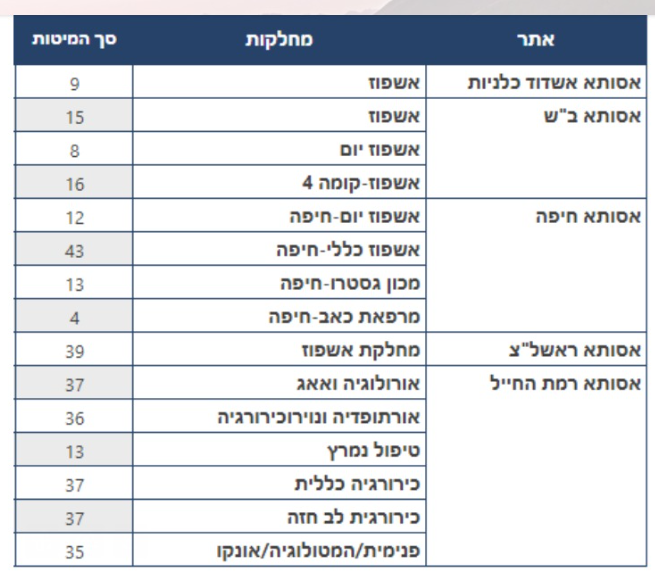

In [7]:
df = pd.read_excel("/content/all_years_with_LOS.xlsx")
df.columns = df.columns.str.strip()

department_mapping = {
    "כירורגית לב חזה": [
        "כיר' בית חזה",
        "כיר' כלי דם",
        "צנתורים וקרדיולוגיה",
        "אלקטרופיזיולוגיה/צינתורים פריפרים",
        "קרדיולוגיה"
    ],
    "אורולוגיה ואאג": [
        "אורולוגיה",
        "אף אוזן וגרון",
        "כירורגיית פה ולסת"
    ],
    "כירורגיה כללית": [
        "גינקולוגיה וילוד",
        "פלסטיקה",
        "כירורגיה כללית"
    ],
    "אורתופדיה ונוירוכירורגיה": [
        "אורטופדיה",
        "נוירוכירורגיה",
        "רדיוכירורגיה"
    ],
    "פנימית/המטולוגיה/אונקו": [
        "עיניים",
        "אשפוז",
        "אונקולוגיה - כימותרפיה",
        "IVF אשפוזי"
    ]
}

df["Activity Type Name"] = df["Activity Type Name"].astype(str)

df["Department"] = None

for dept_name, activity_types in department_mapping.items():
    df.loc[df["Activity Type Name"].isin(activity_types), "Department"] = dept_name

col_list = df.columns.tolist()
if "Department" in col_list:
    col_list.insert(col_list.index("Activity Type Name") + 1, col_list.pop(col_list.index("Department")))
    df = df[col_list]

df.to_excel("/content/all_years_with_LOS_and_Departments.xlsx", index=False)

In [9]:
import pandas as pd

df = pd.read_excel("/content/all_years_with_procedure_names - FINALL.xlsx")
df.columns = df.columns.str.strip()
df["Activity Type Name"] = df["Activity Type Name"].astype(str)

department_mapping = {
    "כירורגית לב חזה": [
        "כיר' בית חזה",
        "כיר' כלי דם",
        "צנתורים וקרדיולוגיה",
        "אלקטרופיזיולוגיה/צינתורים פריפרים",
        "קרדיולוגיה"
    ],
    "פנימית/המטולוגיה/אונקו": [
        "עיניים",
        "אשפוז",
        "אונקולוגיה - כימותרפיה",
        "אשפוזי IVF"
    ],
    "אורתופדיה ונוירוכירורגיה": [
        "אורטופדיה",
        "נוירוכירורגיה",
        "רדיוכירורגיה"
    ],
    "אורולוגיה ואאג": [
        "אורולוגיה",
        "אף אוזן וגרון",
        "כירורגיית פה ולסת"
    ],
    "כירורגיה כללית": [
        "גינקולוגיה וילוד",
        "פלסטיקה",
        "כירורגיה כללית"
    ]
}

df["Department"] = None

for dept_name, activity_types in department_mapping.items():
    df.loc[df["Activity Type Name"].isin(activity_types), "Department"] = dept_name

col_list = df.columns.tolist()
if "Department" in col_list:
    col_list.insert(col_list.index("Activity Type Name") + 1, col_list.pop(col_list.index("Department")))
    df = df[col_list]

df.to_excel("/content/all_years_with_procedure_and_departments.xlsx", index=False)

In [10]:
import pandas as pd

df = pd.read_excel("/content/all_years_with_procedure_and_departmentsFF.xlsx")
df.columns = df.columns.str.strip()

df["Recovery Room Exit Date"] = pd.to_datetime(df["Recovery Room Exit Date"], errors="coerce")
df["Post-Surgery Discharge Date"] = pd.to_datetime(df["Post-Surgery Discharge Date"], errors="coerce")

records = []
for _, row in df.iterrows():
    dept = row["Department"]
    start = row["Recovery Room Exit Date"]
    end = row["Post-Surgery Discharge Date"]
    if pd.isna(dept) or pd.isna(start) or pd.isna(end):
        continue
    for single_date in pd.date_range(start, end - pd.Timedelta(days=1)):
        records.append({
            "date": pd.to_datetime(single_date),
            "department": dept
        })

occ_df = pd.DataFrame(records)

occ_summary = occ_df.groupby(["date", "department"]).size().reset_index(name="occupied_beds")

max_beds_map = {
    "אורולוגיה ואאג": 37,
    "אורתופדיה ונוירוכירורגיה": 36,
    "טיפול נמרץ": 13,
    "כירורגיה כללית": 37,
    "כירורגית לב חזה": 37,
    "פנימית/המטולוגיה/אונקו": 35
}
occ_summary["max_beds"] = occ_summary["department"].map(max_beds_map)
occ_summary["capped_occupied_beds"] = occ_summary[["occupied_beds", "max_beds"]].min(axis=1)
occ_summary["occupancy_pct"] = round(100 * occ_summary["capped_occupied_beds"] / occ_summary["max_beds"], 1)

occ_summary["day_of_week"] = occ_summary["date"].dt.weekday
occ_summary["is_weekend"] = occ_summary["day_of_week"] >= 5
occ_summary["month"] = occ_summary["date"].dt.month

def season_from_month(m):
    if m in [3, 4, 5]: return "spring"
    elif m in [6, 7, 8]: return "summer"
    elif m in [12, 1, 2]: return "winter"
    else: return "autumn"

occ_summary["season"] = occ_summary["month"].apply(season_from_month)
occ_summary = pd.get_dummies(occ_summary, columns=["season"], prefix="season")

final = []
for dept in occ_summary["department"].unique():
    dept_df = occ_summary[occ_summary["department"] == dept].copy().sort_values("date")
    for lag in range(1, 8):
        dept_df[f"lag_{lag}"] = dept_df["capped_occupied_beds"].shift(lag)
    for t in range(1, 8):
        dept_df[f"target_day_{t}"] = dept_df["capped_occupied_beds"].shift(-t)
    final.append(dept_df)

final_df = pd.concat(final, ignore_index=True)

final_df.to_excel("/content/department_occupancy_timeseries.xlsx", index=False)

### Adding significant time records, such as holidays:

In [11]:
!pip install holidays

In [12]:
import pandas as pd
from holidays import Israel

df = pd.read_excel("/content/department_occupancy_timeseries.xlsx")
df.columns = df.columns.str.strip()

# Convert to datetime and create date-only column
df["date"] = pd.to_datetime(df["date"])
df["date_only"] = df["date"].dt.date

# Add Israeli holidays info
il_holidays = Israel(years=range(2017, 2026))
df["is_holiday"] = df["date_only"].isin(il_holidays).astype(int)
df["holiday_name"] = df["date_only"].map(il_holidays)
df["is_holiday_eve"] = df["date_only"].add(pd.Timedelta(days=1)).isin(il_holidays).astype(int)
df["holiday_eve_name"] = df["date_only"].add(pd.Timedelta(days=1)).map(il_holidays)

# move holiday columns right after 'season_winter'
holiday_cols = ["is_holiday", "holiday_name", "is_holiday_eve", "holiday_eve_name"]
cols = df.columns.tolist()

# Ensure all holiday columns are in list
for col in holiday_cols:
    if col not in cols:
        raise ValueError(f"{col} not found in DataFrame")

# Insert after 'season_winter'
insertion_point = cols.index("season_winter") + 1
for col in reversed(holiday_cols):  # insert in reverse to preserve order
    cols.insert(insertion_point, cols.pop(cols.index(col)))

df = df[cols]

df.to_excel("/content/department_occupancy_timeseries_with_holidays.xlsx", index=False)
print("Finished adding holiday columns in the correct location.")

Finished adding holiday columns in the correct location.


### Adding seasons:

In [13]:
import pandas as pd

df = pd.read_excel("/content/department_occupancy_timeseries_with_holidays.xlsx")
df.columns = df.columns.str.strip()

df["target_avg_3days"] = df[["target_day_1", "target_day_2", "target_day_3"]].mean(axis=1)
df["target_avg_7days"] = df[[f"target_day_{i}" for i in range(1, 8)]].mean(axis=1)

df.to_excel("/content/department_occupancy_timeseries_with_targets_avg.xlsx", index=False)

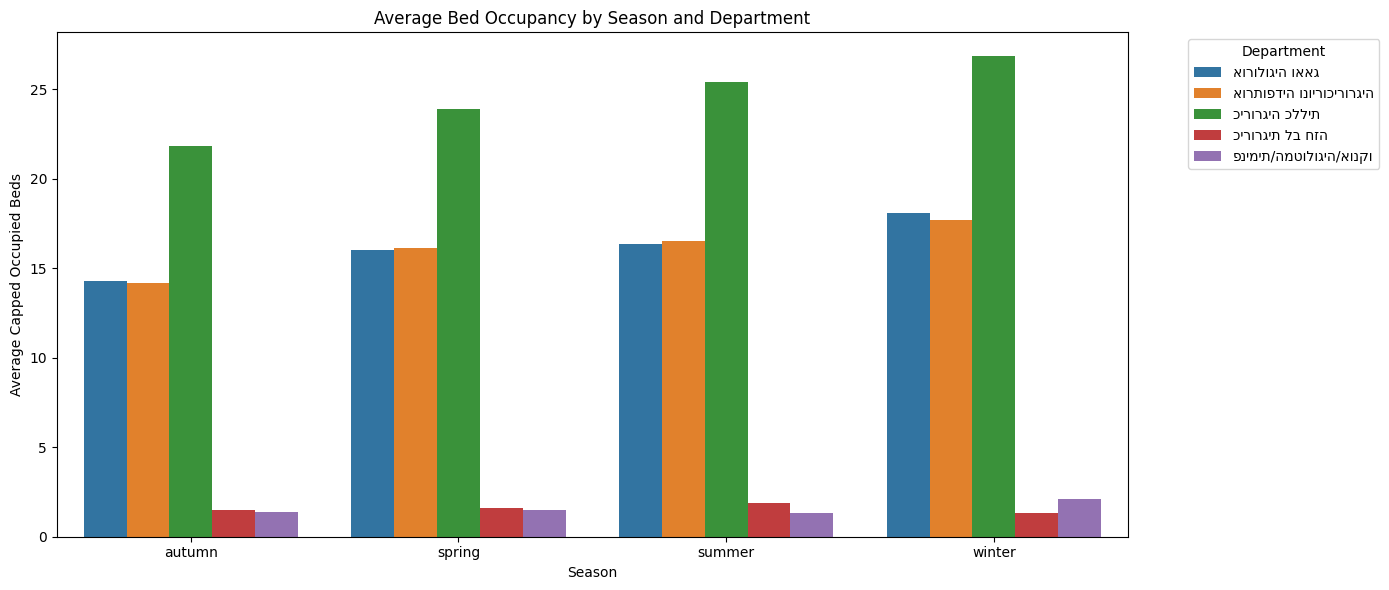

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("/content/department_occupancy_timeseries_with_targets_avg.xlsx")
df["date_only"] = pd.to_datetime(df["date_only"])
df["season"] = df[["season_winter", "season_summer", "season_spring", "season_autumn"]].idxmax(axis=1)
df["season"] = df["season"].str.replace("season_", "")

avg_df = df.groupby(["season", "department"])["capped_occupied_beds"].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=avg_df, x="season", y="capped_occupied_beds", hue="department")
plt.title("Average Bed Occupancy by Season and Department")
plt.ylabel("Average Capped Occupied Beds")
plt.xlabel("Season")
plt.legend(title="Department", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

/tmp/ipython-input-15-2007421937.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dept_data, x="avg_occupied_beds", y="holiday_type", palette="viridis")


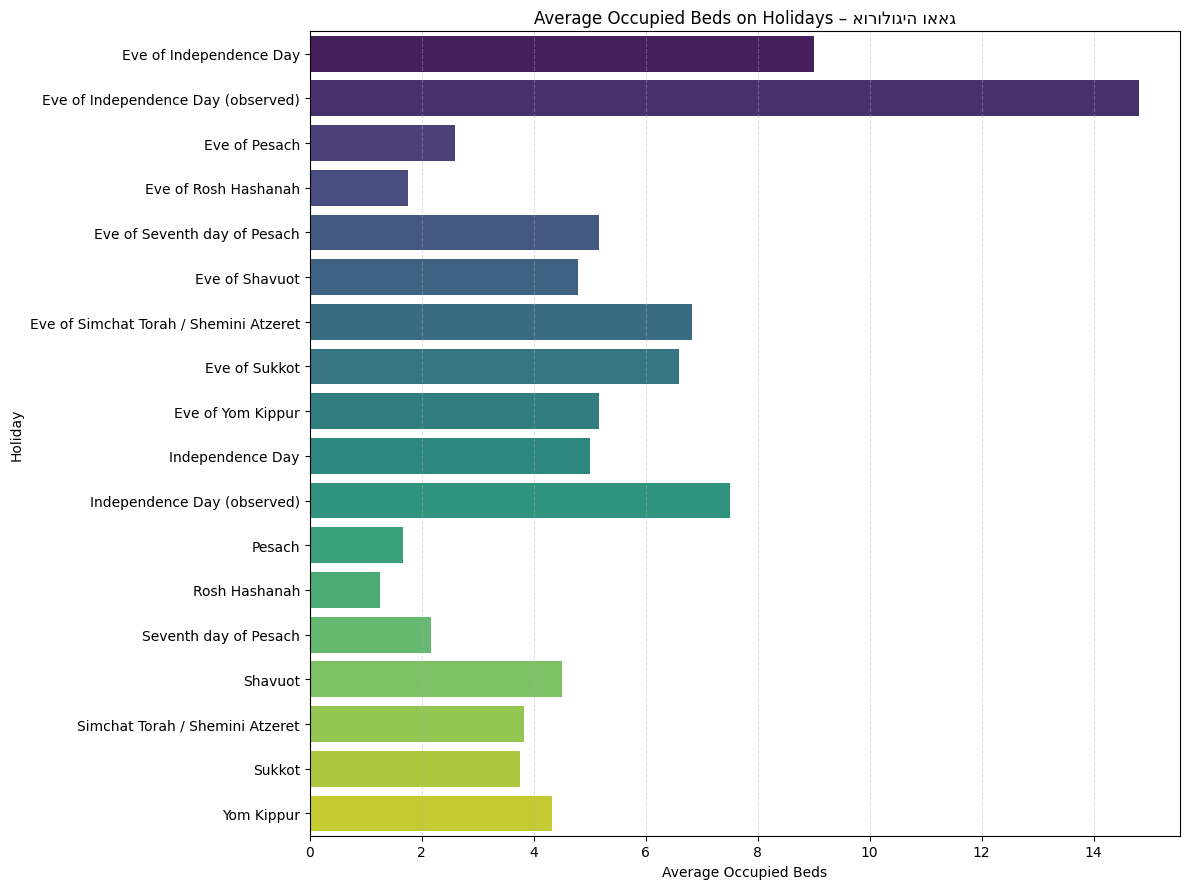

/tmp/ipython-input-15-2007421937.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dept_data, x="avg_occupied_beds", y="holiday_type", palette="viridis")


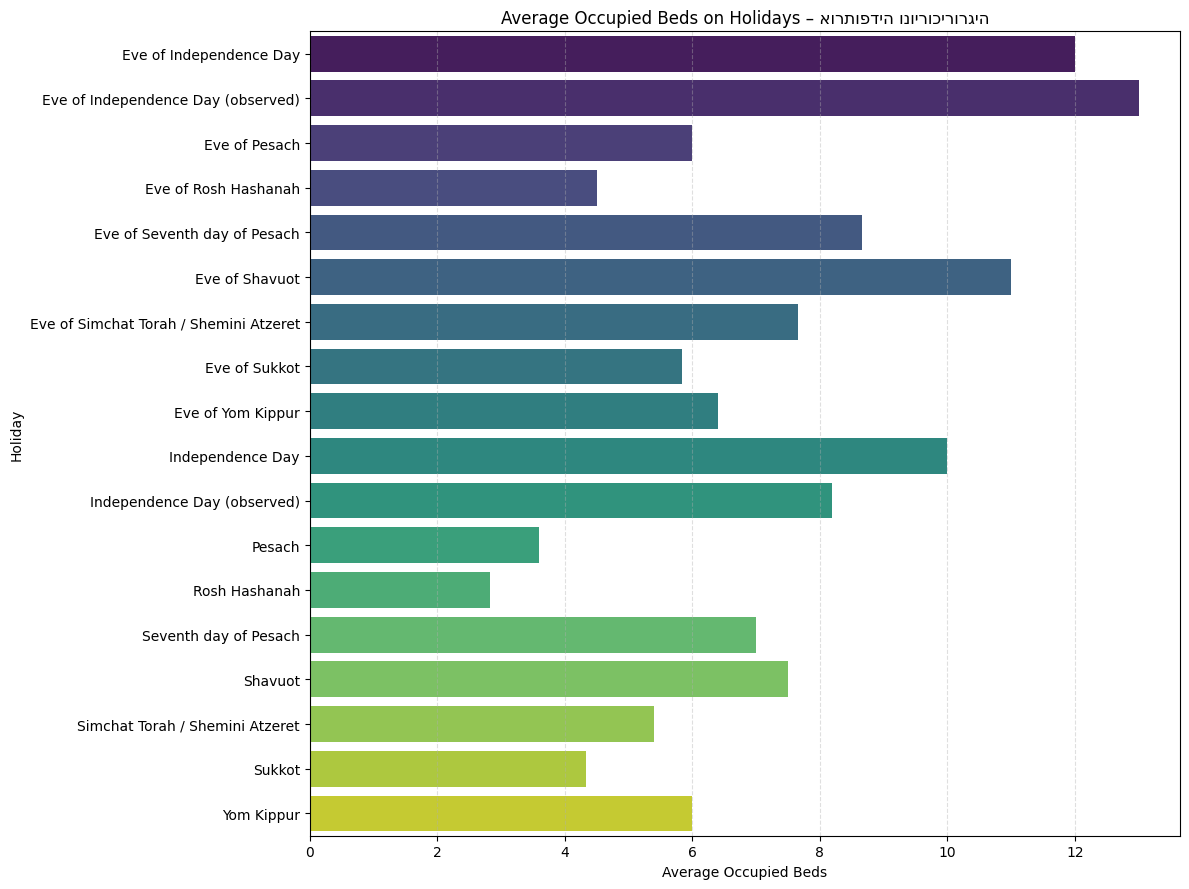

/tmp/ipython-input-15-2007421937.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dept_data, x="avg_occupied_beds", y="holiday_type", palette="viridis")


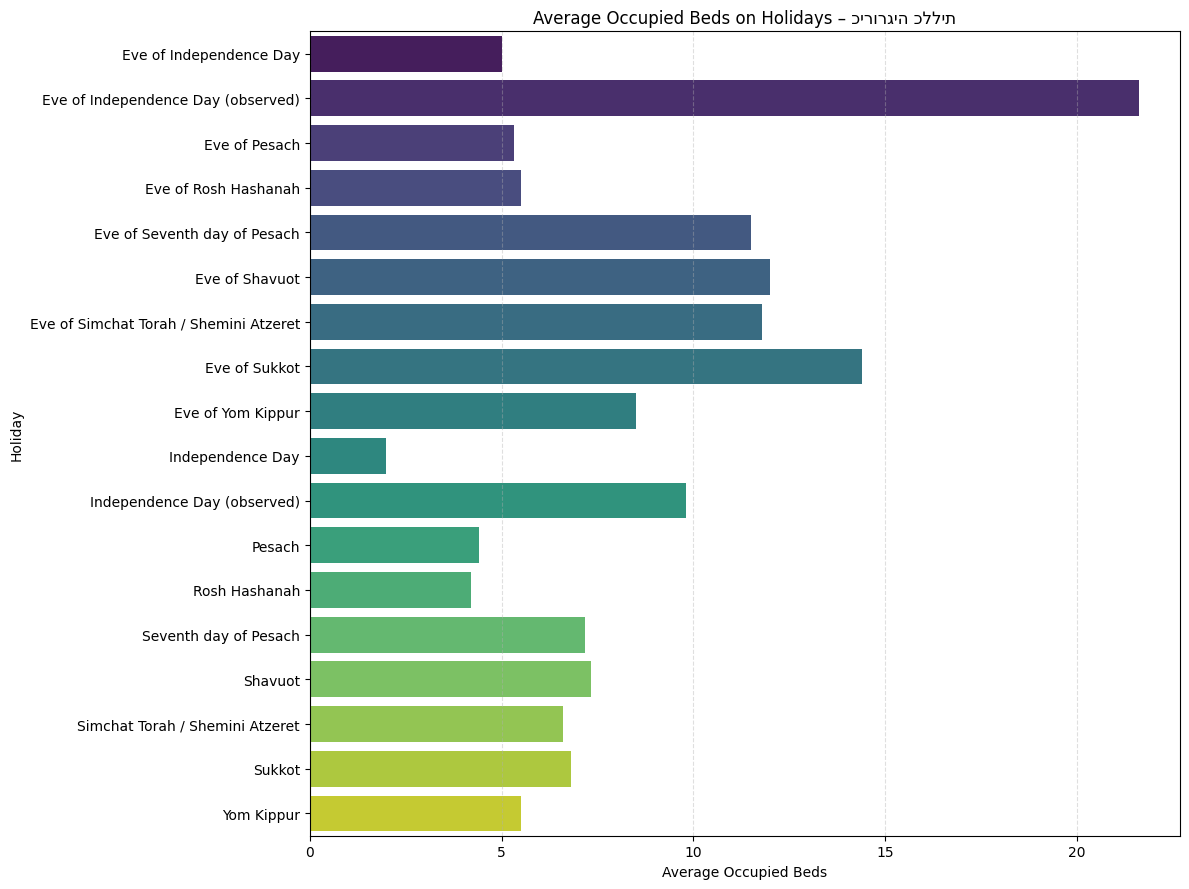

/tmp/ipython-input-15-2007421937.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dept_data, x="avg_occupied_beds", y="holiday_type", palette="viridis")


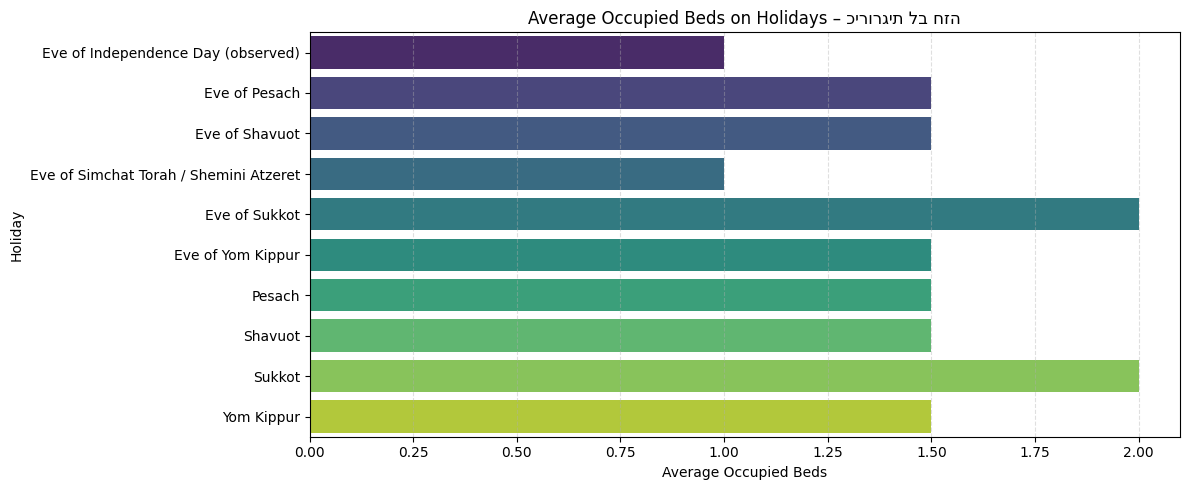

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel("/content/department_occupancy_timeseries_with_targets_avg.xlsx")
df.columns = df.columns.str.strip()
df["date"] = pd.to_datetime(df["date"])

# Filter only rows with holiday or holiday eve
holiday_df = df[(df["is_holiday"] == 1) | (df["is_holiday_eve"] == 1)].copy()

# Create unified holiday label
holiday_df["holiday_type"] = holiday_df.apply(
    lambda row: row["holiday_name"] if row["is_holiday"] == 1 else f"Eve of {row['holiday_eve_name']}",
    axis=1
)

# Compute average occupancy per department and holiday type
summary = (
    holiday_df.groupby(["department", "holiday_type"])["capped_occupied_beds"]
    .mean()
    .reset_index()
    .rename(columns={"capped_occupied_beds": "avg_occupied_beds"})
)

# Plot for each department
for dept in summary["department"].unique():
    dept_data = summary[summary["department"] == dept]

    plt.figure(figsize=(12, max(4, 0.5 * len(dept_data))))  # auto height
    sns.barplot(data=dept_data, x="avg_occupied_beds", y="holiday_type", palette="viridis")
    plt.title(f"Average Occupied Beds on Holidays – {dept}")
    plt.xlabel("Average Occupied Beds")
    plt.ylabel("Holiday")
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [16]:
import pandas as pd

df = pd.read_excel("/content/department_occupancy_timeseries_with_targets_avg.xlsx")
df.columns = df.columns.str.strip()
df = df.sort_values(["department", "date"])

df["date"] = pd.to_datetime(df["date"])

df["rolling_mean_3"] = (
    df.groupby("department")["capped_occupied_beds"]
    .shift(1)
    .rolling(window=3)
    .mean()
    .reset_index(0, drop=True)
)

df["rolling_mean_7"] = (
    df.groupby("department")["capped_occupied_beds"]
    .shift(1)
    .rolling(window=7)
    .mean()
    .reset_index(0, drop=True)
)

df.to_excel("/content/department_occupancy_with_rollingG.xlsx", index=False)

## Training prediction models:

### Simple per-class model (linear / random forest):

A Multi-Output Random Forest Regressor combines two components:

*   RandomForestRegressor: an ensemble of decision trees that predicts a single continuous target.
*   MultiOutputRegressor: a wrapper that turns any single-target regressor into a multi-target one by fitting one independent model per target variable.

Random Forest Base builds n_estimators decision trees on bootstrap samples of the training set. At each split in a tree, a random subset of features is considered, promoting diversity among trees.Final prediction for one target is the average of all tree outputs (for regression).

Multi-Output Wrapping internally clones the base Random Forest for each column in target matrix y_train (shape [n_samples, n_targets]). Each clone is trained independently on the same feature matrix X_train but with a different single-target vector. At prediction time, each forest produces its own target prediction, and the wrapper aggregates them into a multi-dimensional output.

Chose this model because we have multiple continuous outcomes to predict from the same feature set and you value robustness and ease of use over modeling inter-target dependencies explicitly. This model fits as a baseline before moving to more complex multi-target methods (e.g., multi-task neural networks or stacked ensembles).

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df = df.sort_values(["department", "date"])

# Features
feature_cols = [
    "day_of_week", "is_weekend", "is_holiday", "is_holiday_eve",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "rolling_mean_3", "rolling_mean_7"
]

# Targets
target_cols = [
    "target_day_1", "target_day_2", "target_day_3",
    "target_day_4", "target_day_5", "target_day_6", "target_day_7",
    "target_avg_3days", "target_avg_7days"
]

# Collect results
all_results = []

for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].copy()
    df_dept = df_dept.dropna(subset=target_cols)

    X = df_dept[feature_cols]
    y = df_dept[target_cols]

    # Time-based split (not random)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    # Model
    base_model = RandomForestRegressor(n_estimators=100, random_state=SEED)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate and collect results
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    all_results.extend([
        {"department": dept, "target": target_cols[i], "MAE": round(mae[i], 2), "RMSE": round(rmse[i], 2), "R2": round(r2[i], 2)}
        for i in range(len(target_cols))
    ])

    for i, col in enumerate(target_cols):
        actual = y_test.iloc[:, i]
        pred = y_pred[:, i]

        plt.figure(figsize=(10, 5))
        plt.plot(actual.values, label="Actual", marker='o')
        plt.plot(pred, label="Predicted", marker='x')
        plt.title(f"Actual vs Predicted – {dept}, {col}")
        plt.xlabel("Sample Index")
        plt.ylabel("Bed Occupancy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 6))
        plt.scatter(actual, pred, alpha=0.6)
        min_val = min(min(actual), min(pred))
        max_val = max(max(actual), max(pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{dept} – {col}: Prediction vs. Reality")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Create and sort results
results_df = pd.DataFrame(all_results).sort_values(["department", "target"])

print("\n Final Summary – All Departments")
for dept, group in results_df.groupby("department"):
    print(f"\n Department: {dept}")
    for _, row in group.iterrows():
        print(f"{row['target']}: MAE={row['MAE']}, RMSE={row['RMSE']}, R2={row['R2']}")

Output hidden; open in https://colab.research.google.com to view.

In [18]:
!pip install arabic-reshaper python-bidi --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 7.2 MB/s eta 0:00:00


### Gradient Boosting:

A Multi-Output Histogram-Based Gradient Boosting Regressor combines two components:

* **HistGradientBoostingRegressor**: an implementation of gradient boosting that first bins continuous features into histograms and then builds an ensemble of decision trees to minimize a specified loss. This approach speeds up training and reduces memory usage compared to standard gradient-boosting implementations.  
* **MultiOutputRegressor**: a wrapper that converts any single-target regressor into a multi-target one by fitting one independent model per target variable.

Histogram-Based Gradient Boosting builds `max_iter` trees in a sequential manner, where each new tree corrects the residual errors of the ensemble so far. By binning features, it accelerates split-finding and handles large datasets efficiently. Final predictions for each target are averaged across the ensemble of trees.

Multi-Output Wrapping internally clones the base HistGradientBoostingRegressor for each column in the target matrix `y_train` (shape `[n_samples, n_targets]`). Each clone is trained independently on the same feature matrix `X_train` but with its own single-target vector. At prediction time, each model produces its own target prediction, and the wrapper aggregates them into a multi-dimensional output.

Chose this model because it combines high predictive power and efficiency on large tabular data, while still providing robustness against overfitting and minimal preprocessing. It serves as a strong baseline before exploring more complex multi-target methods (e.g., multi-task neural networks or stacked ensembles).  

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib import rcParams

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

rcParams['font.family'] = 'DejaVu Sans'
def reshape_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df = df.sort_values(["department", "date"])

# Feature and target columns
feature_cols = [
    "day_of_week", "is_weekend", "is_holiday", "is_holiday_eve",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "rolling_mean_3", "rolling_mean_7"
]

target_cols = [
    "target_day_1", "target_day_2", "target_day_3",
    "target_day_4", "target_day_5", "target_day_6", "target_day_7",
    "target_avg_3days", "target_avg_7days"
]

# Drop rows with missing values
df = df.dropna(subset=feature_cols + target_cols)

# Initialize results
all_results = []

# Loop over departments
for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].copy()

    X = df_dept[feature_cols]
    y = df_dept[target_cols]

    # Time-aware split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    # Model training
    base_model = HistGradientBoostingRegressor(max_iter=100, random_state=SEED)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # Prediction
    y_pred = model.predict(X_test)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    all_results.extend([
        {
            "department": dept,
            "target": target_cols[i],
            "MAE": round(mae[i], 2),
            "RMSE": round(rmse[i], 2),
            "R2": round(r2[i], 2)
        }
        for i in range(len(target_cols))
    ])

    y_test_np = y_test.values
    y_pred_np = np.array(y_pred)
    dept_reshaped = reshape_rtl(dept)

    for i, name in enumerate(target_cols):
        plt.figure(figsize=(10, 5))
        plt.plot(y_test_np[:, i], label="Actual", marker='o')
        plt.plot(y_pred_np[:, i], label="Predicted", marker='x')
        plt.title(f"Actual vs Predicted – {dept_reshaped}, {name}")
        plt.xlabel("Sample Index")
        plt.ylabel("Bed Occupancy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 6))
        plt.scatter(y_test_np[:, i], y_pred_np[:, i], alpha=0.5)
        min_val = min(y_test_np[:, i].min(), y_pred_np[:, i].min())
        max_val = max(y_test_np[:, i].max(), y_pred_np[:, i].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{dept_reshaped} – {name}: Prediction vs. Reality")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Display results (summary)
results_df = pd.DataFrame(all_results).sort_values(["department", "target"])
print("\nFinal Summary – All Departments")
for dept, group in results_df.groupby("department"):
    print(f"\n Department: {dept}")
    for _, row in group.iterrows():
        print(f"{row['target']}: MAE={row['MAE']}, RMSE={row['RMSE']}, R2={row['R2']}")

Output hidden; open in https://colab.research.google.com to view.

### XGBoost:

A Multi-Output XGBoost Regressor combines two components:

* **XGBRegressor**: a gradient boosting algorithm from the XGBoost library that builds an ensemble of decision trees sequentially, optimizing a differentiable loss function via gradient descent and incorporating regularization (L1/L2) to improve generalization.  
* **MultiOutputRegressor**: a wrapper that converts any single-target regressor into a multi-target one by fitting one independent model per target variable.

XGBRegressor trains `n_estimators` trees, where each subsequent tree learns to correct the residuals (errors) of the current ensemble. The `learning_rate` parameter controls the contribution of each new tree, helping to prevent overfitting by shrinking the step size. XGBoost also accelerates training via efficient handling of sparse data and supports column/row subsampling for further regularization.

Multi-Output Wrapping internally clones the base XGBRegressor for each column in the target matrix `y_train` (shape `[n_samples, n_targets]`). Each clone is trained on the same feature matrix `X_train` but with its own single-target vector. During prediction, each model produces its respective target's forecast, and the wrapper aggregates these into a multi-dimensional output.

Chose this model because it delivers high predictive accuracy on tabular data, handles missing values natively, and provides feature importance metrics—all with reasonable training speed. It serves as a robust baseline before exploring more complex multi-target approaches (e.g., multi-task neural networks or stacked ensembles).  

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

def reshape_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df = df.sort_values(["department", "date"])

# Feature and target columns
feature_cols = [
    "day_of_week", "is_weekend", "is_holiday", "is_holiday_eve",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "rolling_mean_3", "rolling_mean_7"
]

target_cols = [
    "target_day_1", "target_day_2", "target_day_3",
    "target_day_4", "target_day_5", "target_day_6", "target_day_7",
    "target_avg_3days", "target_avg_7days"
]

# Collect results
all_results = []

# Loop over departments
for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].copy()
    df_dept = df_dept.dropna(subset=feature_cols + target_cols)
    if df_dept.empty:
        continue

    X = df_dept[feature_cols]
    y = df_dept[target_cols]

    # Time-aware split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    # Train XGBoost Regressor
    base_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=SEED)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    all_results.extend([
        {
            "department": dept,
            "target": target_cols[i],
            "MAE": round(mae[i], 2),
            "RMSE": round(rmse[i], 2),
            "R2": round(r2[i], 2)
        }
        for i in range(len(target_cols))
    ])

    y_test_np = y_test.values
    y_pred_np = np.array(y_pred)
    dept_rtl = reshape_rtl(dept)

    for i, name in enumerate(target_cols):
        plt.figure(figsize=(10, 5))
        plt.plot(y_test_np[:, i], label="Actual", marker='o')
        plt.plot(y_pred_np[:, i], label="Predicted", marker='x')
        plt.title(f"Actual vs Predicted – {dept_rtl}, {name}")
        plt.xlabel("Sample Index")
        plt.ylabel("Bed Occupancy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 6))
        plt.scatter(y_test_np[:, i], y_pred_np[:, i], alpha=0.5)
        min_val = min(y_test_np[:, i].min(), y_pred_np[:, i].min())
        max_val = max(y_test_np[:, i].max(), y_pred_np[:, i].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f" {dept_rtl} – {name}: Prediction vs. Reality")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Final summary
results_df = pd.DataFrame(all_results).sort_values(["department", "target"])
print("\n Final Summary – All Departments")
for dept, group in results_df.groupby("department"):
    print(f"\n Department: {dept}")
    for _, row in group.iterrows():
        print(f"{row['target']}: MAE={row['MAE']}, RMSE={row['RMSE']}, R2={row['R2']}")

Output hidden; open in https://colab.research.google.com to view.

### Bi-LSTM:
### Sequential model (Bi-LSTM)

A Bidirectional Long Short-Term Memory (Bi-LSTM) network processes time-series data in both forward and backward directions to capture past and future context.

* **Bidirectional LSTM layers**: two LSTM layers run in opposite temporal directions, allowing the model to learn dependencies from both previous and subsequent time steps.  
* **Dense output layer**: maps the final hidden states to a multi-dimensional prediction vector, producing one forecast per target variable in a single forward pass.

Bi-LSTM training optimizes a sequence-to-vector loss (e.g., mean squared error) over all forecast horizons simultaneously. The bidirectional structure helps the network understand seasonality, trend shifts, and autocorrelations more effectively than unidirectional RNNs.

Chose this model because it excels at capturing complex temporal patterns in occupancy data—and it delivered the best results in the key papers on which we based our approach.  

In [21]:
pip install tensorflow

In [22]:
!pip install arabic-reshaper python-bidi

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional

import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

def reshape_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

# Load dataset
df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df = df.dropna(subset=[
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "target_day_1", "target_day_2", "target_day_3", "target_day_4",
    "target_day_5", "target_day_6", "target_day_7",
    "target_avg_3days", "target_avg_7days"
])
df = df.sort_values(["department", "date"])

# Define columns
feature_cols = [f"lag_{i}" for i in range(1, 8)]
target_cols = [
    "target_day_1", "target_day_2", "target_day_3",
    "target_day_4", "target_day_5", "target_day_6", "target_day_7",
    "target_avg_3days", "target_avg_7days"
]

all_results = []

# Loop over departments for training + evaluation
for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].copy()

    X = df_dept[feature_cols].values
    y = df_dept[target_cols].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle=False, test_size=0.2)

    input_layer = Input(shape=(1, X_scaled.shape[2]))
    x = Bidirectional(LSTM(64, return_sequences=False))(input_layer)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(len(target_cols))(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    all_results.extend([
        {
            "department": dept,
            "target": target_cols[i],
            "MAE": round(mae[i], 2),
            "RMSE": round(rmse[i], 2),
            "R2": round(r2[i], 2)
        }
        for i in range(len(target_cols))
    ])

    dept_rtl = reshape_rtl(dept)

    for i, name in enumerate(target_cols):
        plt.figure(figsize=(10, 5))
        plt.plot(y_test[:, i], label="Actual", marker='o')
        plt.plot(y_pred[:, i], label="Predicted", marker='x')
        plt.title(f"Actual vs Predicted – {dept_rtl}, {name}")
        plt.xlabel("Sample Index")
        plt.ylabel("Bed Occupancy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 6))
        plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
        min_val = min(y_test[:, i].min(), y_pred[:, i].min())
        max_val = max(y_test[:, i].max(), y_pred[:, i].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        plt.xlabel("Actual Occupancy")
        plt.ylabel("Predicted Occupancy")
        plt.title(f" {dept_rtl} – {name}: Prediction vs. Reality")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

results_df = pd.DataFrame(all_results).sort_values(["department", "target"])
print("\n Final Summary – All Departments")
for dept, group in results_df.groupby("department"):
    print(f"\n Department: {dept}")
    for _, row in group.iterrows():
        print(f"{row['target']}: MAE={row['MAE']}, RMSE={row['RMSE']}, R2={row['R2']}")

historical_rows = []

for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].copy()

    X = df_dept[feature_cols].values
    y = df_dept[target_cols].values
    dates = df_dept["date"].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    input_layer = Input(shape=(1, X_scaled.shape[2]))
    x = Bidirectional(LSTM(64, return_sequences=False))(input_layer)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(len(target_cols))(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_scaled, y, epochs=100, batch_size=16, verbose=0)

    y_pred = model.predict(X_scaled)

    for i in range(len(X_scaled)):
        for j, target in enumerate(target_cols):
            historical_rows.append({
                "department": dept,
                "date": pd.to_datetime(dates[i]),
                "target_name": target,
                "actual": y[i, j],
                "predicted": y_pred[i, j]
            })

historical_df = pd.DataFrame(historical_rows)
historical_df.to_excel("historical_forecasts_vs_actuals.xlsx", index=False)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime

Creating Departments_Info (Bed Capacity):

In [26]:
import pandas as pd

departments_info = pd.DataFrame({
    "department": [
        "אורולוגיה ואאג",
        "אורתופדיה ונוירוכירורגיה",
        "כירורגיה כללית",
        "כירורגית לב חזה",
        "פנימית/המטואונקולוגיה/אונקו"
    ],
    "bed_capacity": [37, 36, 37, 37, 35],
    "color": ["#27ae60", "#2980b9", "#e67e22", "#3498db", "#9b59b6"]
})

departments_info.to_excel("departments_info.xlsx", index=False)

Reading the Patients_Data patient file:

In [28]:
patients_df = pd.read_excel("/content/all_years_with_procedure_names - FINALL.xlsx")

Creating a Legend:

In [29]:
legend_df = pd.DataFrame([
    {"column_name": "forecast_date", "description": "The date on which the forecast was generated"},
    {"column_name": "target_day", "description": "How many days ahead the forecast refers to"},
    {"column_name": "predicted_occupancy", "description": "Predicted number of occupied inpatient beds for the department"},
    {"column_name": "actual", "description": "The actual observed occupancy value"},
    {"column_name": "bed_capacity", "description": "The official number of available beds in the department"},
])

In [31]:
import pandas as pd

file_names = [
    "2017_data_with_UTR_F.xlsx",
    "2018_data_with_UTR_F.xlsx",
    "2019_data_with_UTR_F.xlsx",
    "2020_data_with_UTR_F.xlsx",
    "2021_data_with_UTR_F.xlsx",
    "2022_data_with_UTR_F.xlsx",
    "2023_data_with_UTR_F.xlsx",
    "2024_data_with_UTR_FINAL.xlsx"
]

all_dfs = []

for file in file_names:
    year = int(file[:4])
    df = pd.read_excel(f"/content/{file}")
    df["year"] = year

    df.columns = df.columns.str.strip()

    if "Actual Surgery Room Entry Date" in df.columns:
        df["Actual Surgery Room Entry Date"] = pd.to_datetime(
            df["Actual Surgery Room Entry Date"], errors="coerce"
        )
        date_col = "Actual Surgery Room Entry Date"
    else:
        raise ValueError("Column 'Actual Surgery Room Entry Date' not found")

    if "room_id" in df.columns:
        room_col = df["room_id"].astype(str)
    else:
        room_col = df.get("Procedure Code", pd.Series(["NA"] * len(df))).astype(str)

    df["unique_case_id"] = (
        df["year"].astype(str) + "_" +
        df["patient_id"].astype(str) + "_" +
        df[date_col].dt.strftime("%Y%m%d") + "_" +
        room_col
    )

    all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)

combined_df.to_excel("All_Years_Utilization_with_ID.xlsx", index=False)

In [32]:
with pd.ExcelWriter("bed_dashboard_data.xlsx") as writer:
    # Historical forecasts by department and date
    historical_df.to_excel(writer, sheet_name="Historical_Forecasts", index=False)

    # Department table with capacity and colors
    departments_info.to_excel(writer, sheet_name="Departments_Info", index=False)

    # The patient table consolidated from all years
    combined_df.to_excel(writer, sheet_name="Patients_Data", index=False)

    # Column explanation table
    legend_df.to_excel(writer, sheet_name="Legend", index=False)

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional

# Load data
df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()

required_cols = [f"lag_{i}" for i in range(1, 8)]
target_cols = [
    "target_day_1", "target_day_2", "target_day_3", "target_day_4",
    "target_day_5", "target_day_6", "target_day_7",
    "target_avg_3days", "target_avg_7days"
]
df = df.dropna(subset=required_cols + target_cols)
df = df.sort_values(["department", "date"])

feature_cols = required_cols
final_rows = []

for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].copy()
    X = df_dept[feature_cols].values
    y = df_dept[target_cols].values
    dates = df_dept["date"].values  # We will use the row date

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    # Build & train model per department
    input_layer = Input(shape=(1, len(feature_cols)))
    x = Bidirectional(LSTM(64, return_sequences=False))(input_layer)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(len(target_cols))(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_scaled, y, epochs=100, batch_size=16, verbose=0)

    # Predict on entire history
    y_pred = model.predict(X_scaled)

    for i in range(len(X_scaled)):
        row = {
            "forecast_base_date": pd.to_datetime(dates[i]).date(),
            "department": dept
        }
        for j, name in enumerate(target_cols):
            row[name] = round(y_pred[i][j], 2)
        final_rows.append(row)

# Save to Excel
forecast_df = pd.DataFrame(final_rows)
forecast_df.to_excel("historical_bed_forecasts.xlsx", index=False)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


This code differs from the first implementation of the model:
This code has Scaling of the targets (y) - the main addition is the use of MinMaxScaler also on the prediction targets, and not just on the inputs.
This fixes the range of y within [0,1] during training and improves the stability of the LSTM optimization, instead of training on raw values only.

In addition, there is also a clean performance evaluation (out-of-sample only) - the first version included prediction on all the data (in-sample) to create “historical forecasts”, and then an evaluation on the test set. The second version focuses on the train/test split only, without re-fitting the model on all the data, to get a more reliable measure of future performance.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional

import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

# Fix seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

def reshape_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

# Load dataset
df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df = df.dropna(subset=[
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "target_day_1", "target_day_2", "target_day_3", "target_day_4",
    "target_day_5", "target_day_6", "target_day_7",
    "target_avg_3days", "target_avg_7days"
])
df = df.sort_values(["department", "date"])

# Define features and targets
feature_cols = [f"lag_{i}" for i in range(1, 8)]
target_cols = [
    "target_day_1", "target_day_2", "target_day_3",
    "target_day_4", "target_day_5", "target_day_6", "target_day_7",
    "target_avg_3days", "target_avg_7days"
]

all_results = []

# Loop over departments
for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].copy()

    X = df_dept[feature_cols].values
    y = df_dept[target_cols].values

    # Normalize
    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.2)

    # Build Bi-LSTM model
    input_layer = Input(shape=(1, X_scaled.shape[2]))
    x = Bidirectional(LSTM(64, return_sequences=False))(input_layer)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output_layer = Dense(len(target_cols))(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    # Inverse transform to real scale
    y_test_real = y_scaler.inverse_transform(y_test)
    y_pred_real = y_scaler.inverse_transform(y_pred)

    # Metrics
    mae = mean_absolute_error(y_test_real, y_pred_real, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real, multioutput='raw_values'))
    r2 = r2_score(y_test_real, y_pred_real, multioutput='raw_values')

    all_results.extend([
        {
            "department": dept,
            "target": target_cols[i],
            "MAE": round(mae[i], 2),
            "RMSE": round(rmse[i], 2),
            "R2": round(r2[i], 2)
        }
        for i in range(len(target_cols))
    ])

    dept_rtl = reshape_rtl(dept)

    for i, name in enumerate(target_cols):
        # Line plot
        plt.figure(figsize=(10, 5))
        plt.plot(y_test_real[:, i], label="Actual", marker='o')
        plt.plot(y_pred_real[:, i], label="Predicted", marker='x')
        plt.title(f"Actual vs Predicted – {dept_rtl}, {name}")
        plt.xlabel("Sample Index")
        plt.ylabel("Bed Occupancy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Scatter plot
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test_real[:, i], y_pred_real[:, i], alpha=0.5)
        min_val = min(y_test_real[:, i].min(), y_pred_real[:, i].min())
        max_val = max(y_test_real[:, i].max(), y_pred_real[:, i].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        plt.xlabel("Actual Occupancy")
        plt.ylabel("Predicted Occupancy")
        plt.title(f"{dept_rtl} – {name}: Prediction vs. Reality")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Summary
results_df = pd.DataFrame(all_results).sort_values(["department", "target"])
print("\n Final Summary – All Departments")
for dept, group in results_df.groupby("department"):
    print(f"\n Department: {dept}")
    for _, row in group.iterrows():
        print(f"{row['target']}: MAE={row['MAE']}, RMSE={row['RMSE']}, R2={row['R2']}")

Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


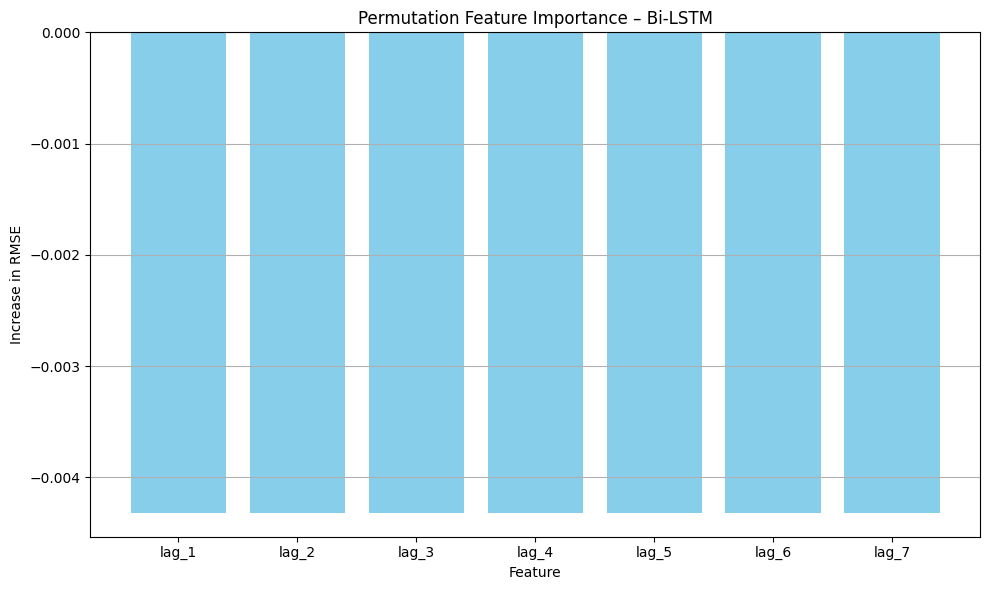

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from copy import deepcopy

def compute_permutation_importance(model, X_test, y_test, feature_names):
    baseline_preds = model.predict(X_test)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))

    importances = []
    for i in range(X_test.shape[1]):
        X_perm = deepcopy(X_test)
        np.random.shuffle(X_perm[:, i, 0])
        perm_preds = model.predict(X_perm)
        perm_rmse = np.sqrt(mean_squared_error(y_test, perm_preds))
        importance = perm_rmse - baseline_rmse
        importances.append(importance)

    return np.array(importances), baseline_rmse

feature_names = [f"lag_{i}" for i in range(1, 8)]
importances, baseline = compute_permutation_importance(model, X_test, y_test, feature_names)

# Barplot:
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances, color='skyblue')
plt.title("Permutation Feature Importance – Bi-LSTM")
plt.ylabel("Increase in RMSE")
plt.xlabel("Feature")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

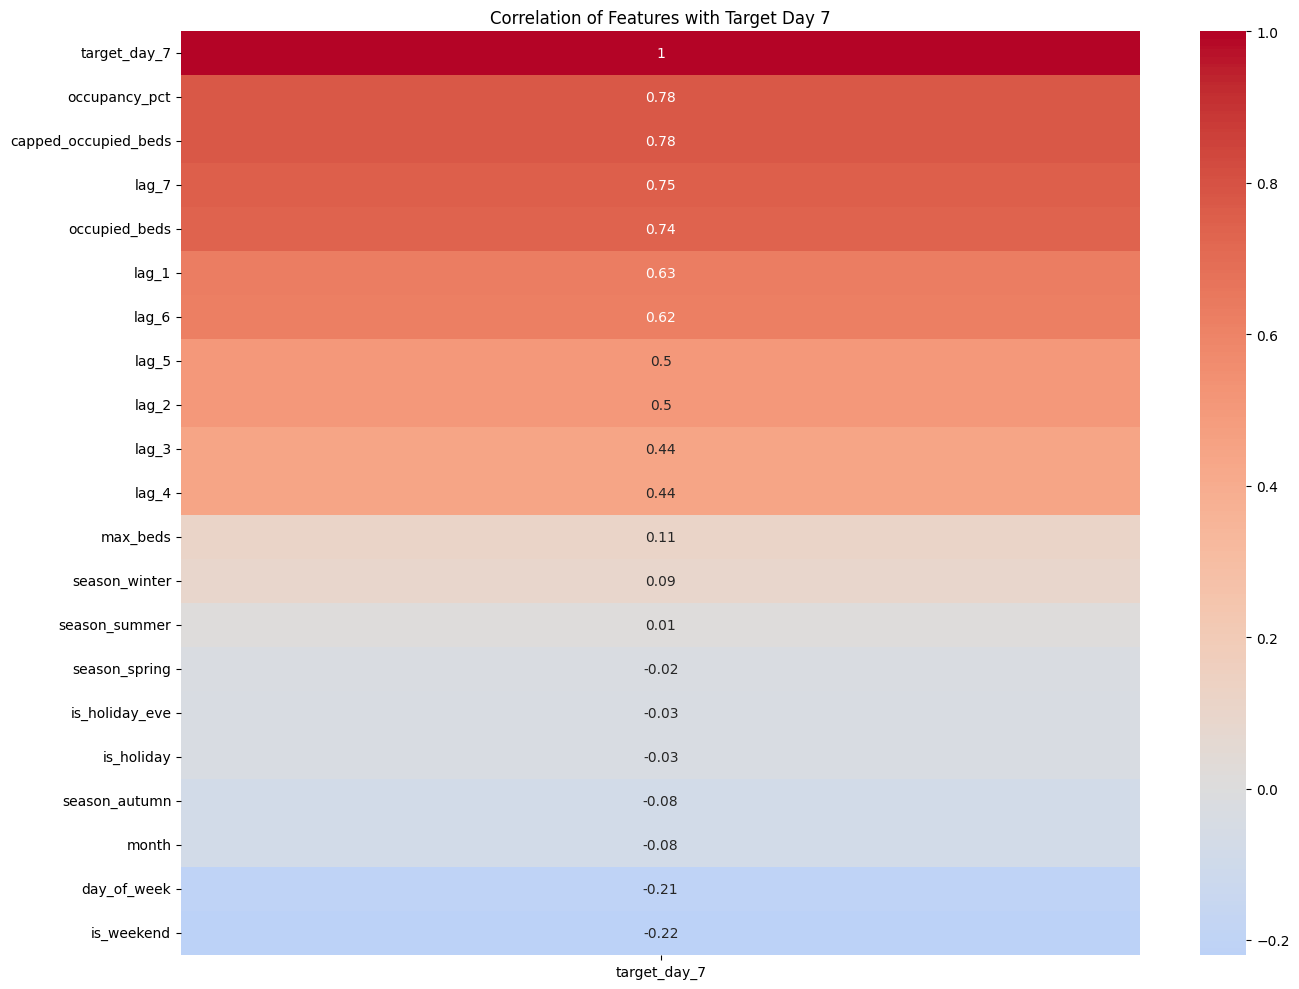

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_cols = [
    'occupied_beds', 'max_beds', 'capped_occupied_beds', 'occupancy_pct',
    'day_of_week', 'is_weekend', 'month',
    'season_autumn', 'season_spring', 'season_summer', 'season_winter',
    'is_holiday', 'is_holiday_eve',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
    'target_day_7'
]

corr = df[selected_cols].corr().round(2)

plt.figure(figsize=(14, 10))
sns.heatmap(corr[['target_day_7']].sort_values(by='target_day_7', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of Features with Target Day 7")
plt.tight_layout()
plt.show()

### Simple per-series model (SARIMAX)

A Seasonal AutoRegressive Integrated Moving Average (SARIMAX) model extends ARIMA (ARIMA is a time series forecasting model that combines autoregressive regression (AR) to capture dependence on previous values, integration (I) to remove trend by difference, and moving average (MA) to model past errors.) by modeling both non-seasonal and seasonal patterns in a univariate time series.

* **Non-seasonal components (`order=(p,d,q)`):**  
  - **AR(p)=1**: includes one lag of the series to capture short-term dependence.  
  - **I(d)=1**: applies first differencing to remove linear trend.  
  - **MA(q)=1**: models the current error as a combination of the previous forecast error.
* **Seasonal components (`seasonal_order=(P,D,Q,s)`):**  
  - **P=1**: includes one seasonal autoregressive term at lag `s`.  
  - **D=1**: applies seasonal differencing once to remove weekly cycles.  
  - **Q=0**: no seasonal moving-average term.  
  - **s=7**: specifies a weekly seasonality period (7 days).

The model is instantiated with:
```python
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 7))

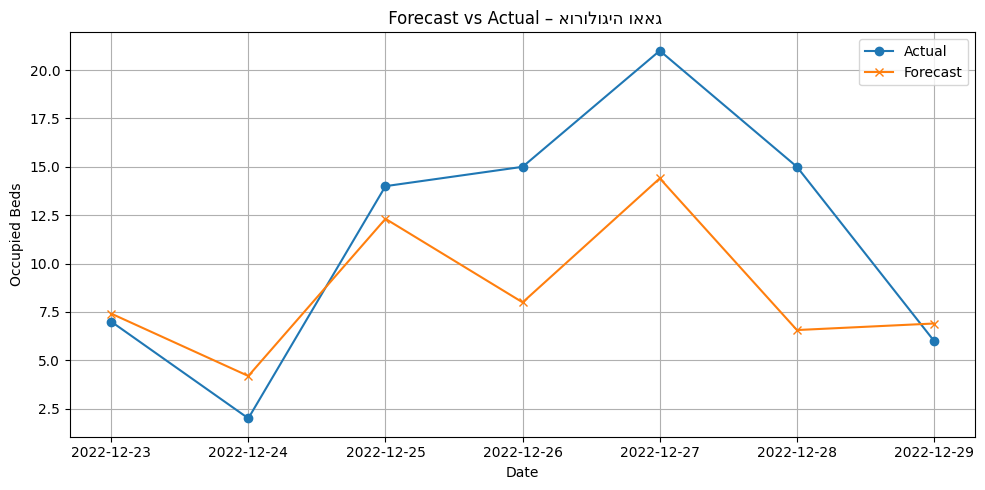

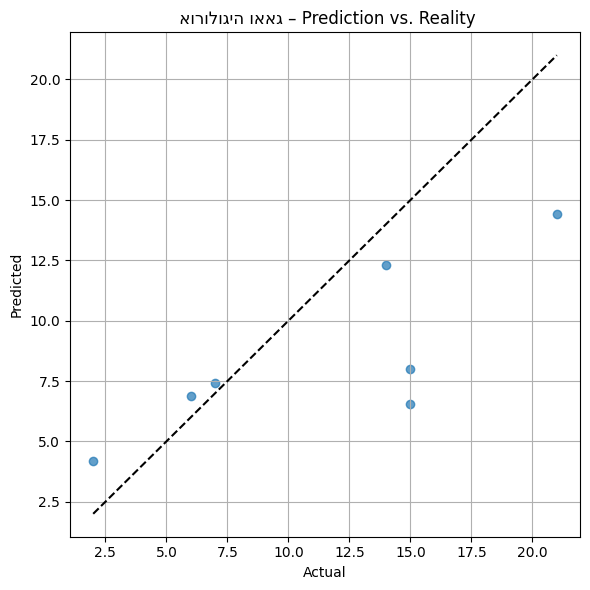

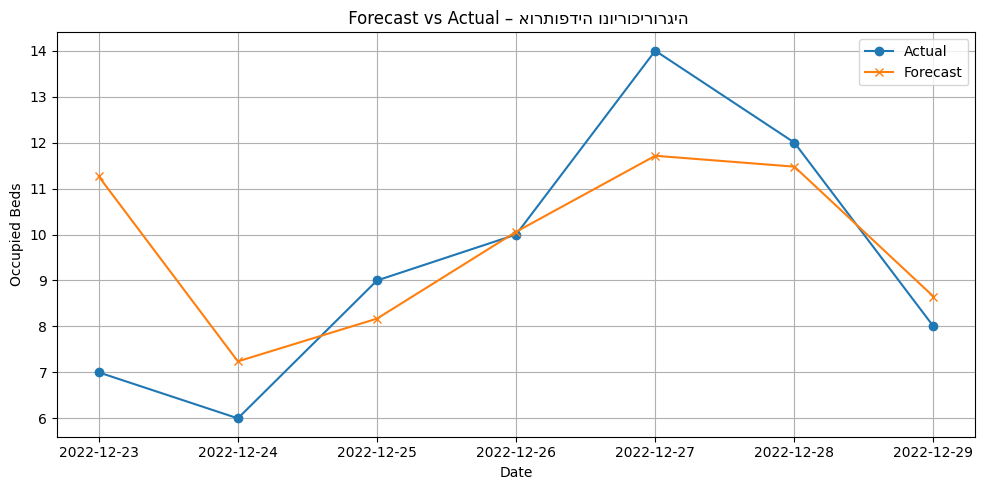

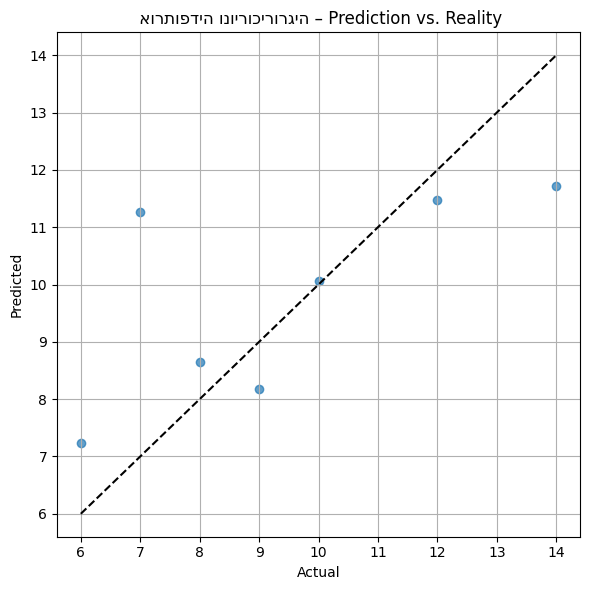

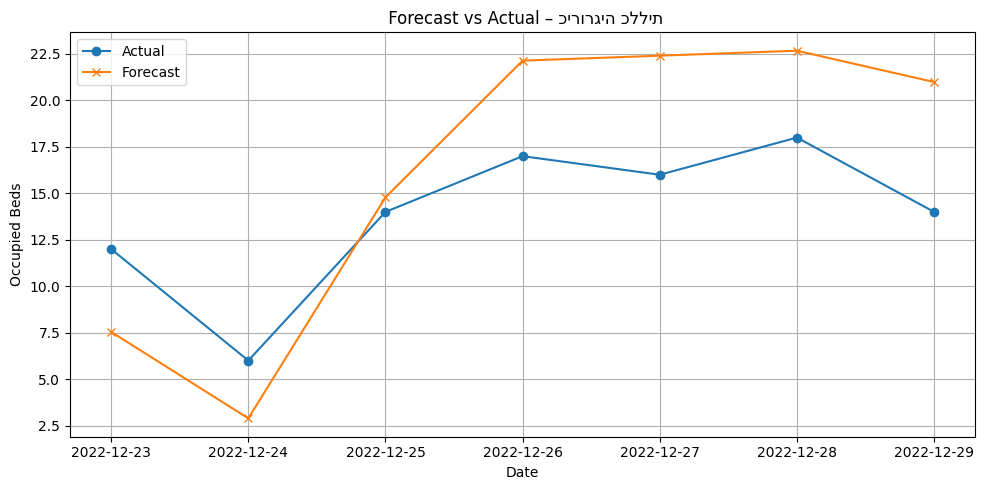

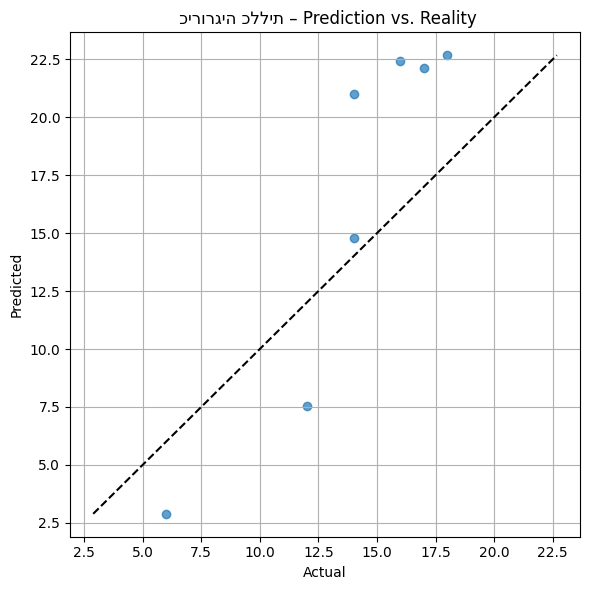

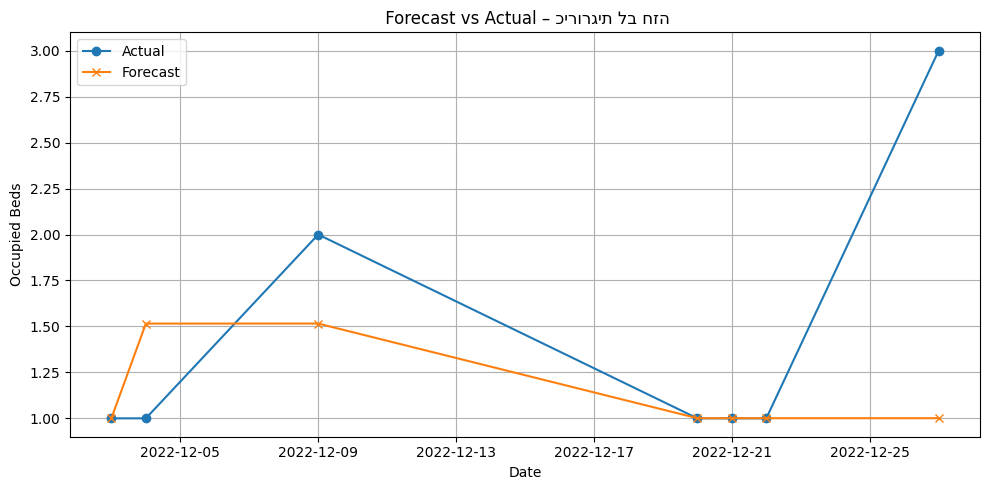

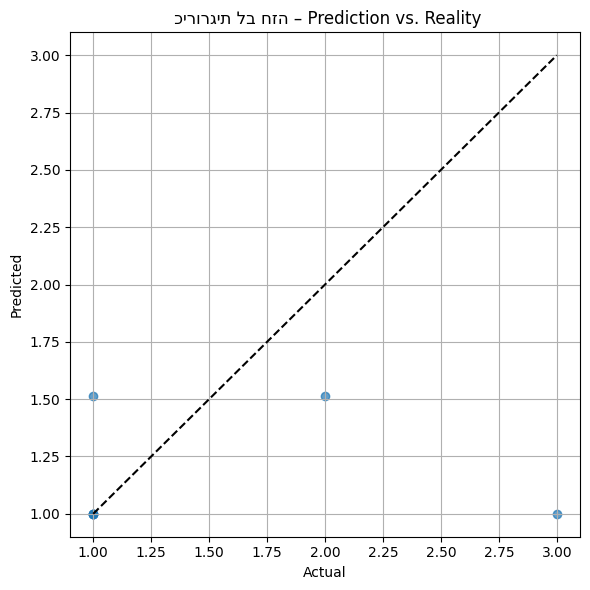

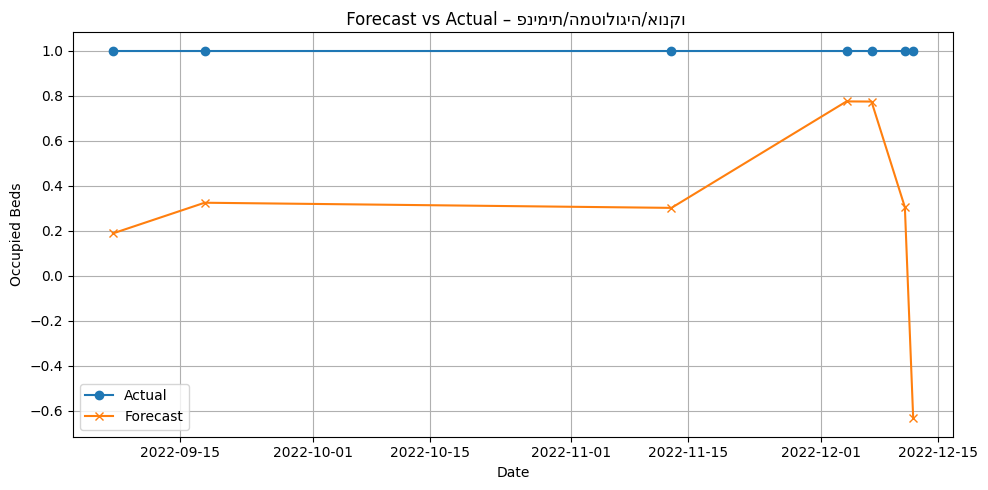

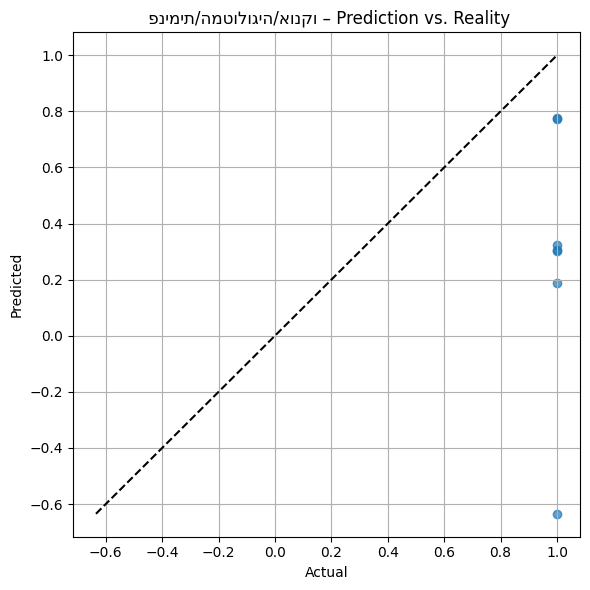


 Final Summary – All Departments

 Department: כירורגית לב חזה
MAE: 0.43, RMSE: 0.8, R2: -0.21

 Department: פנימית/המטולוגיה/אונקו
MAE: 0.71, RMSE: 0.83, R2: 0.0

 Department: אורתופדיה ונוירוכירורגיה
MAE: 1.41, RMSE: 1.94, R2: 0.45

 Department: אורולוגיה ואאג
MAE: 3.89, RMSE: 4.96, R2: 0.34

 Department: כירורגיה כללית
MAE: 4.51, RMSE: 4.9, R2: -0.74


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

warnings.filterwarnings("ignore")

# Load data
df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["department", "date"])

results = []
departments_metrics = []

# Loop over departments
for dept in df["department"].dropna().unique():
    dept_df = df[df["department"] == dept].copy()
    dept_df = dept_df.set_index("date").sort_index()

    series = dept_df["capped_occupied_beds"].dropna()

    if len(series) < 30:
        continue

    # Split: last 7 days = test
    train = series.iloc[:-7]
    test = series.iloc[-7:]

    # Fit SARIMAX
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 0, 7))
    fitted_model = model.fit(disp=False)

    # Forecast
    forecast = fitted_model.forecast(steps=7)

    # Evaluation
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    r2 = r2_score(test, forecast)

    departments_metrics.append({
        "department": dept,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R2": round(r2, 2)
    })

    # Store daily results
    for i, (actual, pred) in enumerate(zip(test.values, forecast.values), start=1):
        results.append({
            "department": dept,
            "day_ahead": i,
            "actual": actual,
            "predicted": pred,
            "MAE": abs(actual - pred),
            "RMSE": (actual - pred) ** 2,
        })

    # Line chart
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test.values, marker='o', label="Actual")
    plt.plot(test.index, forecast.values, marker='x', label="Forecast")
    plt.title(f" Forecast vs Actual – {dept}")
    plt.xlabel("Date")
    plt.ylabel("Occupied Beds")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(test.values, forecast.values, alpha=0.7)
    min_val = min(test.min(), forecast.min())
    max_val = max(test.max(), forecast.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f" {dept} – Prediction vs. Reality")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create final summary DataFrame
summary_df = pd.DataFrame(departments_metrics).sort_values("MAE")

print("\n Final Summary – All Departments")
for _, row in summary_df.iterrows():
    print(f"\n Department: {row['department']}")
    print(f"MAE: {row['MAE']}, RMSE: {row['RMSE']}, R2: {row['R2']}")

The current code is different from the previous code:
The seasonality parameters in SARIMAX: In the first code, seasonal_order=(1,1,0,7) is used (no seasonal MA part). In the second code, seasonal_order=(1,1,1,7) is chosen (also includes a seasonal MA component, Q=1).

The model constraint settings: In the first code, SARIMAX(train, order=…, seasonal_order=…) is called with the defaults (enforce_stationarity=True, enforce_invertibility=True). In the second code, enforce_stationarity=False, enforce_invertibility=False are added to allow the model greater flexibility in adjusting the parameters.

Calculating and saving performance metrics - In the first code, MAE/RMSE/R² is calculated for the entire department and saved in the departments_metrics structure, and daily results (day_ahead, actual, predicted, MAE and RMSE²) are also saved in the results array. In the second code, the MAE/RMSE for each day for daily prediction (target_day_i) is printed inside the loop, then the average MAE and RMSE for the department level is calculated and saved in all_results.


 Department: אורולוגיה ואאג
target_day_1: MAE=0.89, RMSE=0.89
target_day_2: MAE=1.07, RMSE=1.07
target_day_3: MAE=2.27, RMSE=2.27
target_day_4: MAE=6.16, RMSE=6.16
target_day_5: MAE=7.58, RMSE=7.58
target_day_6: MAE=6.61, RMSE=6.61
target_day_7: MAE=1.22, RMSE=1.22
Overall R²: 0.436


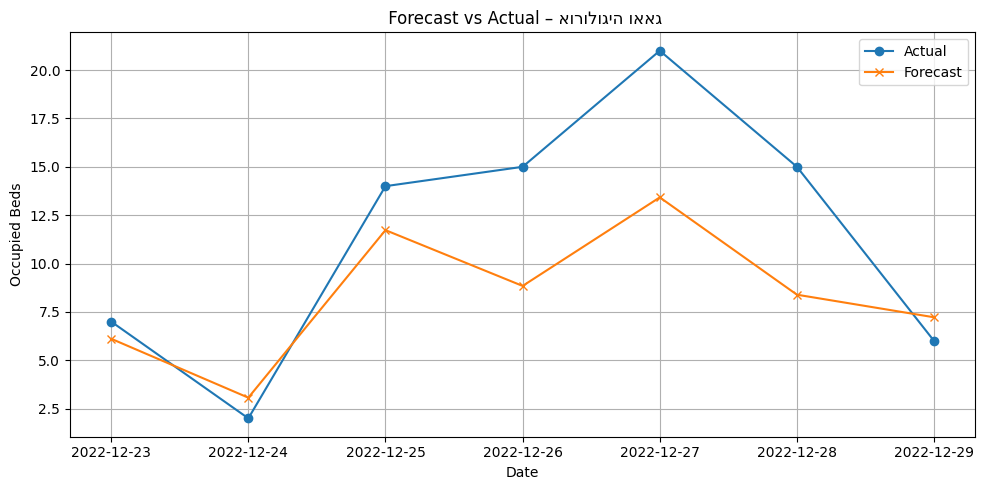

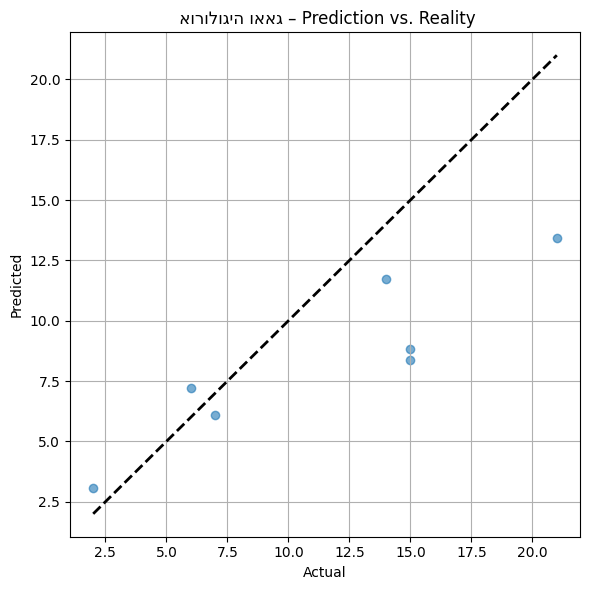


 Department: אורתופדיה ונוירוכירורגיה
target_day_1: MAE=3.07, RMSE=3.07
target_day_2: MAE=1.09, RMSE=1.09
target_day_3: MAE=1.46, RMSE=1.46
target_day_4: MAE=1.35, RMSE=1.35
target_day_5: MAE=3.5, RMSE=3.5
target_day_6: MAE=1.96, RMSE=1.96
target_day_7: MAE=0.92, RMSE=0.92
Overall R²: 0.339


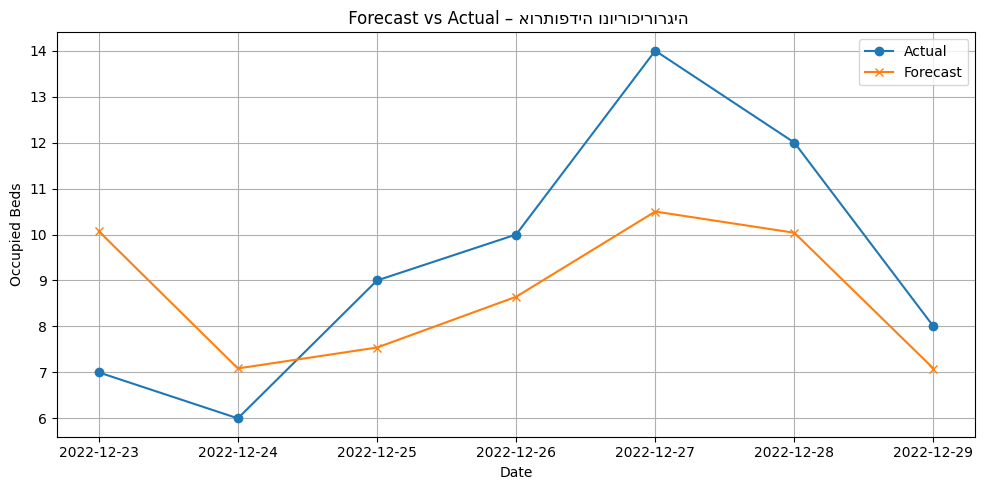

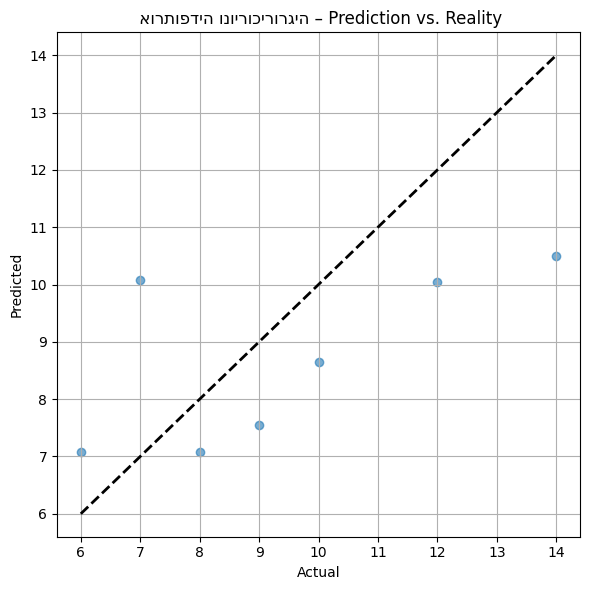


 Department: כירורגיה כללית
target_day_1: MAE=3.54, RMSE=3.54
target_day_2: MAE=2.54, RMSE=2.54
target_day_3: MAE=0.79, RMSE=0.79
target_day_4: MAE=4.34, RMSE=4.34
target_day_5: MAE=5.21, RMSE=5.21
target_day_6: MAE=2.37, RMSE=2.37
target_day_7: MAE=5.76, RMSE=5.76
Overall R²: -0.079


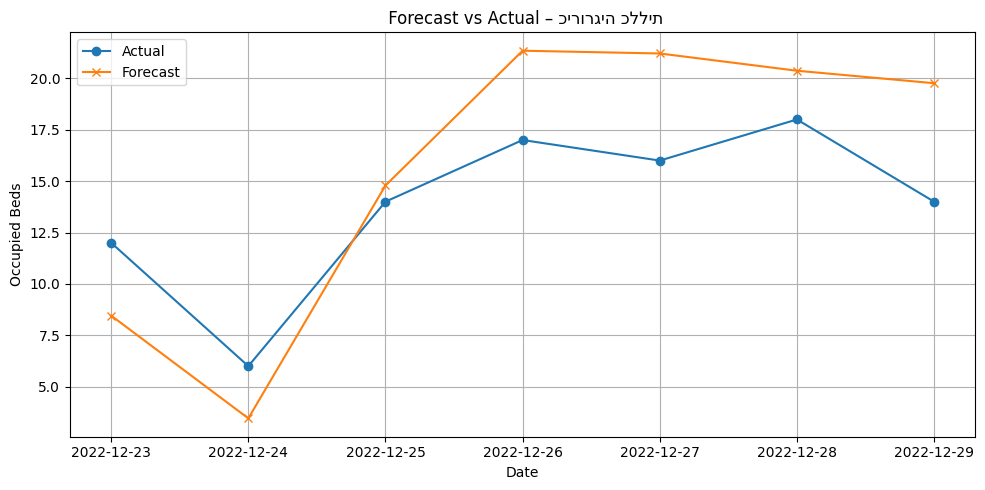

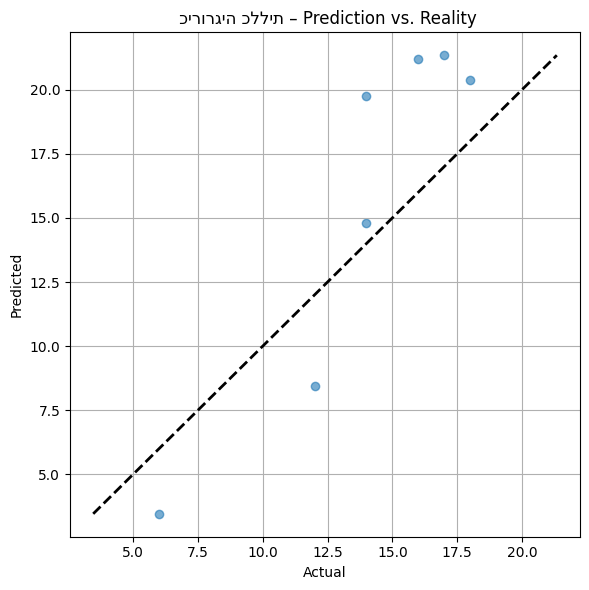


 Department: כירורגית לב חזה
target_day_1: MAE=0.35, RMSE=0.35
target_day_2: MAE=0.14, RMSE=0.14
target_day_3: MAE=0.86, RMSE=0.86
target_day_4: MAE=0.35, RMSE=0.35
target_day_5: MAE=0.39, RMSE=0.39
target_day_6: MAE=0.25, RMSE=0.25
target_day_7: MAE=1.91, RMSE=1.91
Overall R²: -0.304


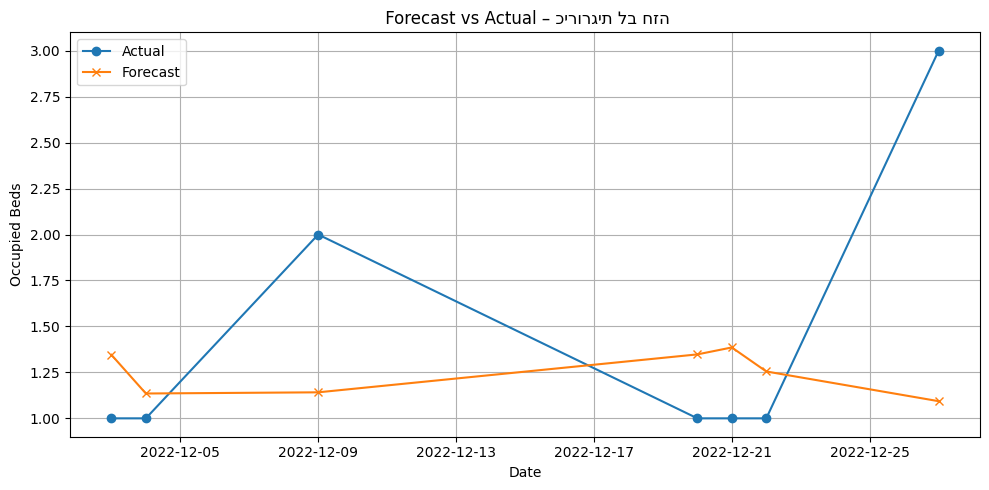

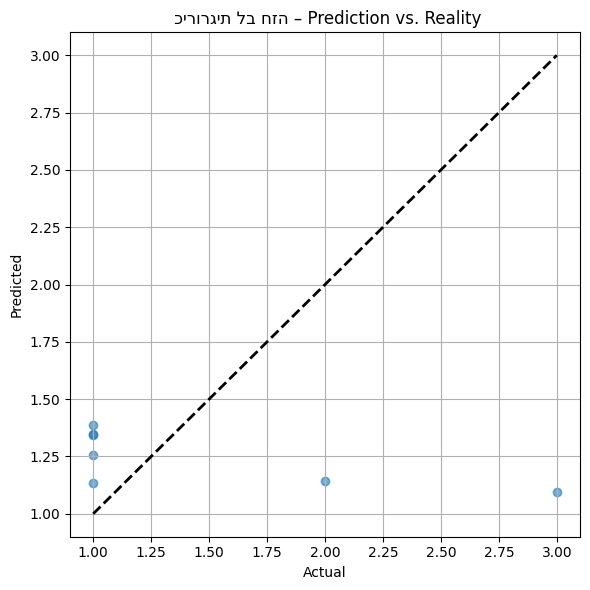


 Department: פנימית/המטולוגיה/אונקו
target_day_1: MAE=0.39, RMSE=0.39
target_day_2: MAE=0.24, RMSE=0.24
target_day_3: MAE=0.01, RMSE=0.01
target_day_4: MAE=1.13, RMSE=1.13
target_day_5: MAE=0.48, RMSE=0.48
target_day_6: MAE=0.25, RMSE=0.25
target_day_7: MAE=0.02, RMSE=0.02
Overall R²: 0.0


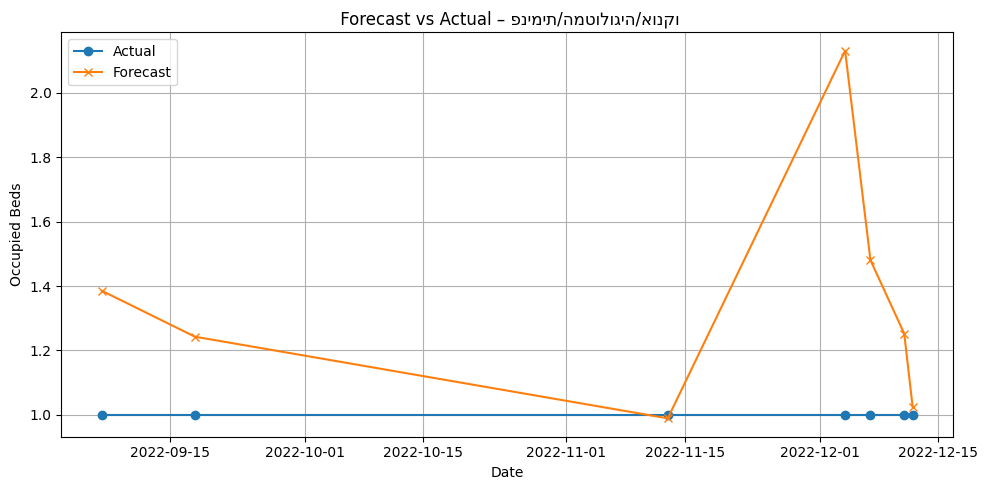

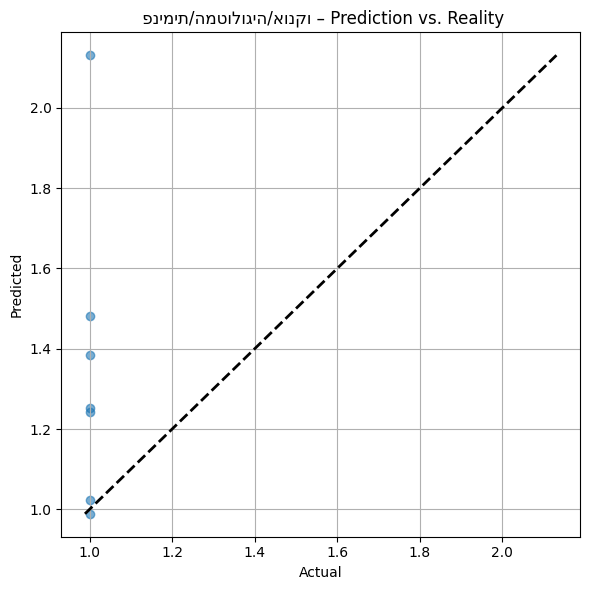


 Final Summary – All Departments:

 אורולוגיה ואאג
Average MAE: 3.69, Average RMSE: 3.69, R²: 0.436

 אורתופדיה ונוירוכירורגיה
Average MAE: 1.91, Average RMSE: 1.91, R²: 0.339

 כירורגיה כללית
Average MAE: 3.51, Average RMSE: 3.51, R²: -0.079

 כירורגית לב חזה
Average MAE: 0.61, Average RMSE: 0.61, R²: -0.304

 פנימית/המטולוגיה/אונקו
Average MAE: 0.36, Average RMSE: 0.36, R²: 0.0


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

warnings.filterwarnings("ignore")

# Load data
df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["department", "date"])

# SARIMAX parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

all_results = []

# Loop over departments
for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].copy()
    ts = df_dept.set_index("date")["capped_occupied_beds"].dropna()

    if len(ts) < 30:
        continue

    train, test = ts[:-7], ts[-7:]

    # Fit model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # Forecast
    forecast = model_fit.forecast(steps=7)

    # Evaluation
    mae_list = []
    rmse_list = []

    print(f"\n Department: {dept}")
    for i in range(len(test)):
        actual = test.iloc[i]
        pred = forecast.iloc[i]
        mae = round(abs(actual - pred), 2)
        rmse = round(np.sqrt((actual - pred) ** 2), 2)
        mae_list.append(mae)
        rmse_list.append(rmse)
        print(f"target_day_{i+1}: MAE={mae}, RMSE={rmse}")

    try:
        r2 = round(r2_score(test, forecast), 3)
        print(f"Overall R²: {r2}")
    except:
        r2 = None
        print("Overall R²: N/A")

    # Append to global results
    all_results.append({
        "department": dept,
        "MAE_avg": round(np.mean(mae_list), 2),
        "RMSE_avg": round(np.mean(rmse_list), 2),
        "R2": r2 if r2 is not None else "N/A"
    })

    # Line plot
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test.values, label="Actual", marker='o')
    plt.plot(test.index, forecast.values, label="Forecast", marker='x')
    plt.title(f" Forecast vs Actual – {dept}")
    plt.xlabel("Date")
    plt.ylabel("Occupied Beds")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(test.values, forecast.values, alpha=0.6)
    min_val = min(test.min(), forecast.min())
    max_val = max(test.max(), forecast.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f" {dept} – Prediction vs. Reality")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#  Final summary
print("\n Final Summary – All Departments:")
for r in all_results:
    print(f"\n {r['department']}")
    print(f"Average MAE: {r['MAE_avg']}, Average RMSE: {r['RMSE_avg']}, R²: {r['R2']}")

### Sequential model (GRU)

A Gated Recurrent Unit (GRU) network is a type of recurrent neural network designed to capture temporal dependencies in sequential data using a simplified gating mechanism.

* **GRU layer**: processes the input sequence of length `n_input` with 64 hidden units. Each GRU cell uses update and reset gates to control the flow of information, allowing the network to retain long-term dependencies without the complexity of LSTM.  
* **Dense output layer**: maps the final GRU hidden state to a vector of length `n_output`, producing one forecast for each future day in a single forward pass.

GRU training minimizes mean squared error between the normalized actual and predicted sequences, and we denormalize the outputs (`pred_denorm = pred * std_val + mean_val`) to compute MAE, RMSE, and R² in the original occupancy scale.

Chose this model because GRUs often achieve similar performance to LSTMs with fewer parameters and faster training, making them well-suited for time-series forecasting on moderate-sized hospital occupancy data.  


 Department: אורולוגיה ואאג
target_day_1: actual=7.0, predicted=5.2
target_day_2: actual=2.0, predicted=5.4
target_day_3: actual=14.0, predicted=5.0
target_day_4: actual=15.0, predicted=4.8
target_day_5: actual=21.0, predicted=5.0
target_day_6: actual=15.0, predicted=5.3
target_day_7: actual=6.0, predicted=5.1


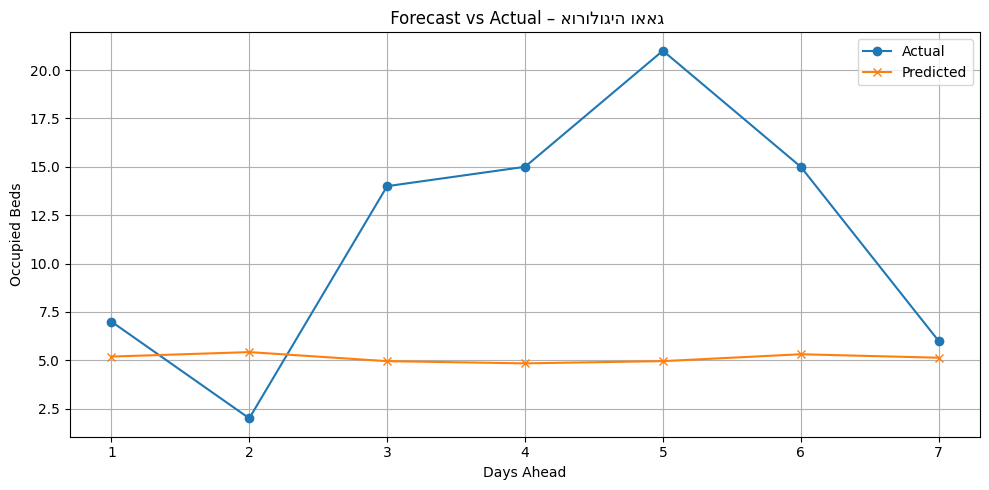

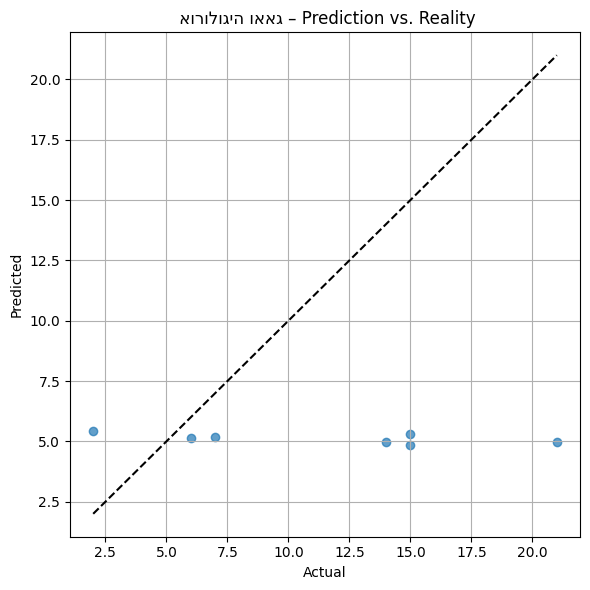


 Department: אורתופדיה ונוירוכירורגיה
target_day_1: actual=7.0, predicted=5.1
target_day_2: actual=6.0, predicted=5.2
target_day_3: actual=9.0, predicted=4.9
target_day_4: actual=10.0, predicted=5.0
target_day_5: actual=14.0, predicted=4.9
target_day_6: actual=12.0, predicted=4.9
target_day_7: actual=8.0, predicted=5.4


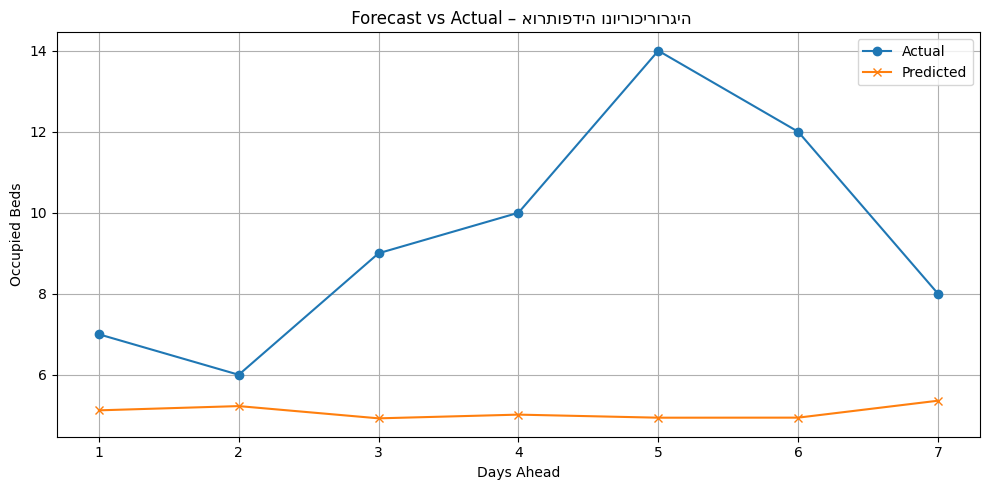

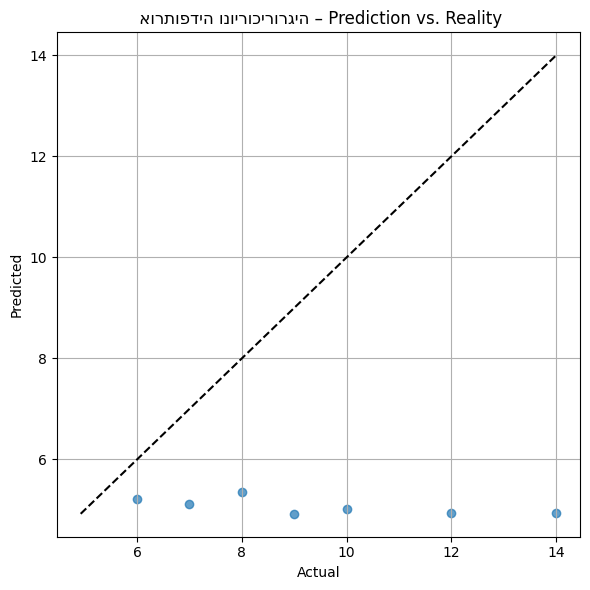


 Department: כירורגיה כללית
target_day_1: actual=12.0, predicted=12.2
target_day_2: actual=6.0, predicted=13.1
target_day_3: actual=14.0, predicted=12.8
target_day_4: actual=17.0, predicted=12.6
target_day_5: actual=16.0, predicted=12.9
target_day_6: actual=18.0, predicted=13.0
target_day_7: actual=14.0, predicted=12.8


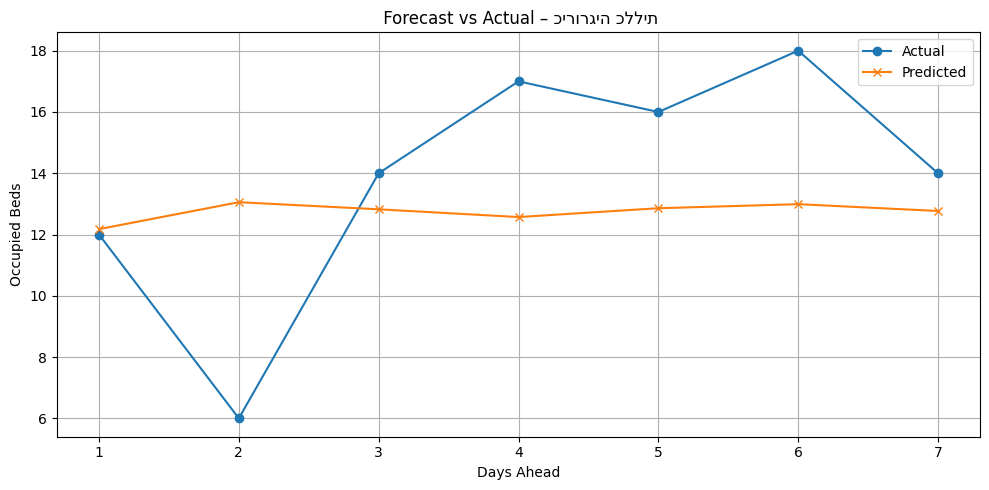

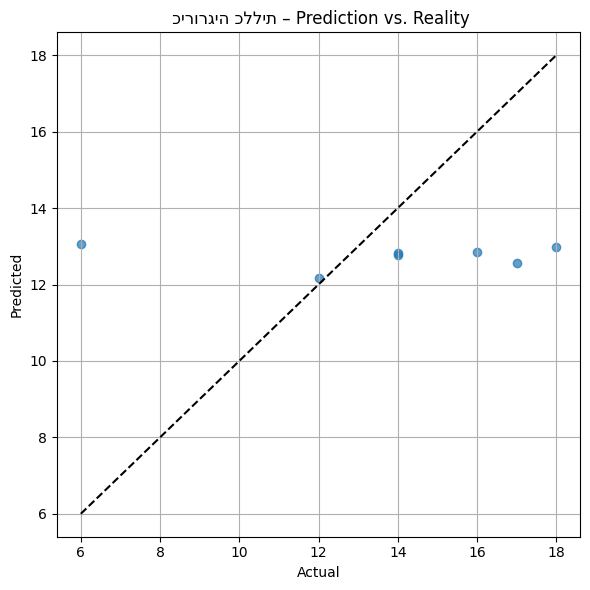


 Department: כירורגית לב חזה
target_day_1: actual=1.0, predicted=1.3
target_day_2: actual=1.0, predicted=1.3
target_day_3: actual=2.0, predicted=1.4
target_day_4: actual=1.0, predicted=1.3
target_day_5: actual=1.0, predicted=1.3
target_day_6: actual=1.0, predicted=1.3
target_day_7: actual=3.0, predicted=1.3


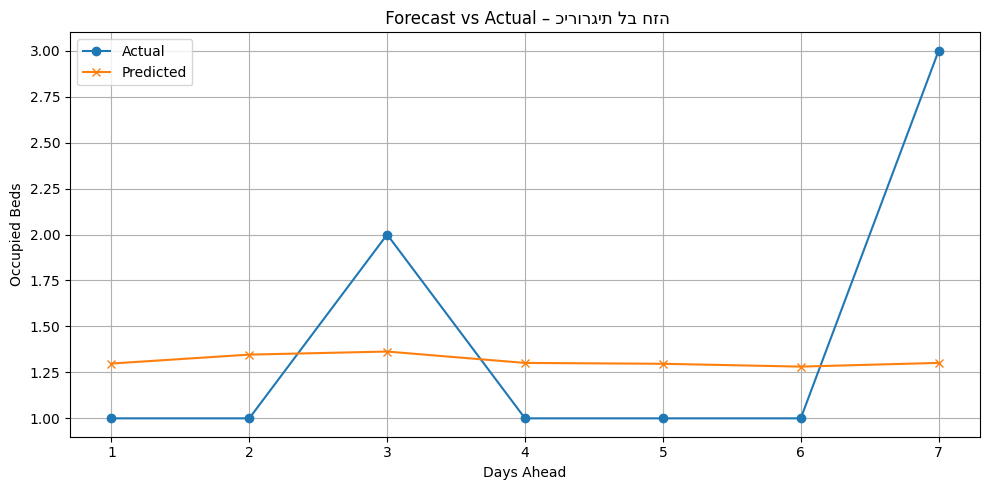

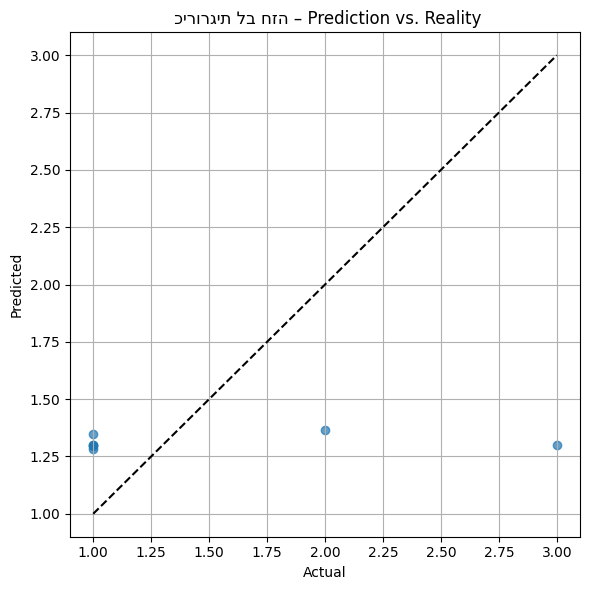


 Department: פנימית/המטולוגיה/אונקו
target_day_1: actual=1.0, predicted=3.3
target_day_2: actual=1.0, predicted=3.3
target_day_3: actual=1.0, predicted=3.3
target_day_4: actual=1.0, predicted=3.3
target_day_5: actual=1.0, predicted=3.3
target_day_6: actual=1.0, predicted=3.4
target_day_7: actual=1.0, predicted=3.3


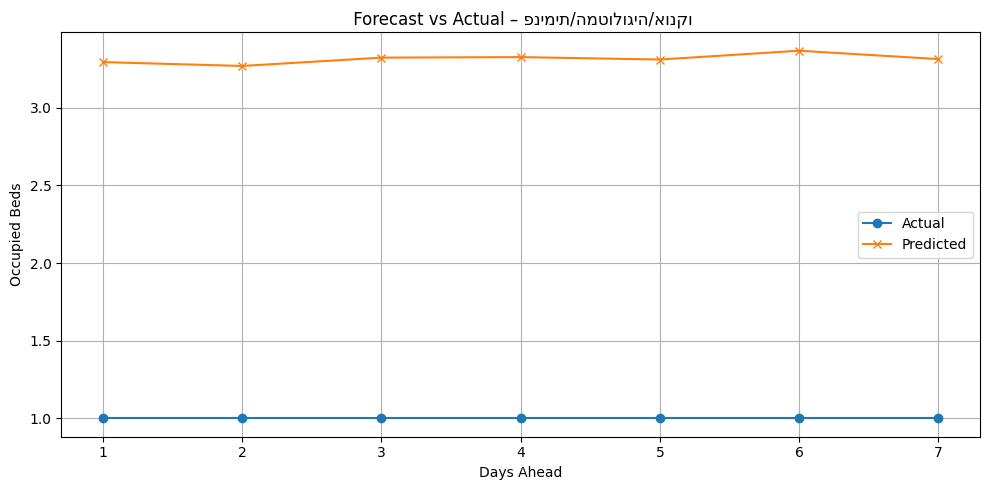

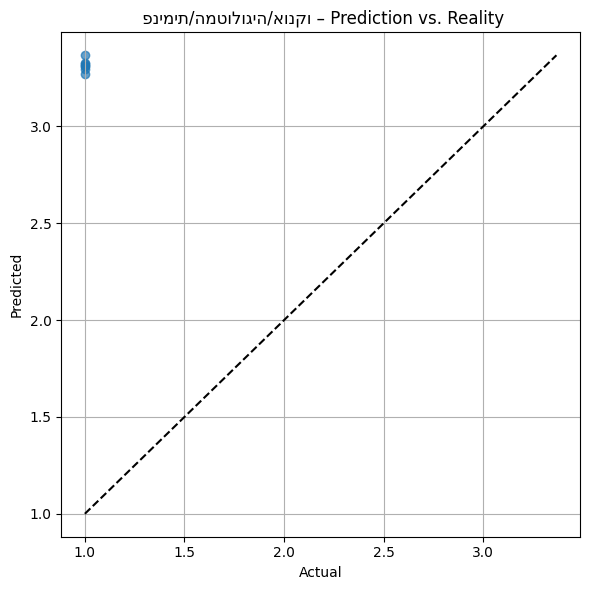


 Final Summary – All Departments:
אורולוגיה ואאג: MAE=7.29, RMSE=8.88, R2=-1.109
אורתופדיה ונוירוכירורגיה: MAE=4.35, RMSE=5.13, R2=-2.865
כירורגיה כללית: MAE=3.17, RMSE=3.91, R2=-0.108
כירורגית לב חזה: MAE=0.55, RMSE=0.73, R2=-0.011
פנימית/המטולוגיה/אונקו: MAE=2.32, RMSE=2.32, R2=0.0


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["department", "date"])

# Parameters
n_input = 14
n_output = 7
results = []

# Run per department
for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].copy()
    series = df_dept["capped_occupied_beds"].values.astype("float32")

    if len(series) < n_input + n_output:
        continue

    # Normalization
    mean_val = np.mean(series)
    std_val = np.std(series)
    series_norm = (series - mean_val) / std_val

    # Split
    split_index = len(series_norm) - (n_input + n_output)
    train_series = series_norm[:split_index]
    test_series = series_norm[split_index - n_input:]

    # Generator
    generator = TimeseriesGenerator(train_series, train_series, length=n_input, batch_size=1)

    # Model
    model = Sequential([
        GRU(64, activation='tanh', input_shape=(n_input, 1)),
        Dense(n_output)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator, epochs=20, verbose=0, callbacks=[EarlyStopping(patience=3)])

    # Forecast
    input_seq = test_series[:n_input].reshape((1, n_input, 1))
    pred = model.predict(input_seq, verbose=0)[0]
    pred_denorm = pred * std_val + mean_val
    actual = series[-n_output:]

    # Evaluate
    mae = mean_absolute_error(actual, pred_denorm)
    rmse = np.sqrt(mean_squared_error(actual, pred_denorm))
    r2 = r2_score(actual, pred_denorm)

    # Print per-day
    print(f"\n Department: {dept}")
    for i in range(n_output):
        print(f"target_day_{i+1}: actual={actual[i]:.1f}, predicted={pred_denorm[i]:.1f}")

    # Line plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_output+1), actual, label="Actual", marker='o')
    plt.plot(range(1, n_output+1), pred_denorm, label="Predicted", marker='x')
    plt.title(f" Forecast vs Actual – {dept}")
    plt.xlabel("Days Ahead")
    plt.ylabel("Occupied Beds")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #  Scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(actual, pred_denorm, alpha=0.7)
    min_val = min(min(actual), min(pred_denorm))
    max_val = max(max(actual), max(pred_denorm))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f" {dept} – Prediction vs. Reality")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Store results
    results.append({
        "department": dept,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "R2": round(r2, 3)
    })

results_df = pd.DataFrame(results).sort_values("department")
print("\n Final Summary – All Departments:")
for _, row in results_df.iterrows():
    print(f"{row['department']}: MAE={row['MAE']}, RMSE={row['RMSE']}, R2={row['R2']}")

### Simple per-class model (k-nearest neighbors)

A Multi-Output k-Nearest Neighbors Regressor combines two components:

* **KNeighborsRegressor**: a non-parametric method that predicts a continuous target by averaging the values of the `k` closest training samples in feature space.  
* **MultiOutputRegressor**: a wrapper that turns any single-target regressor into a multi-target one by fitting one independent model per target variable.

KNN works by computing distances (e.g., Euclidean) between a new sample and all training samples, selecting the `n_neighbors=5` closest points, and returning the mean of their target values. No explicit training is required beyond storing the normalized feature–target pairs.

Multi-Output Wrapping internally clones the base KNeighborsRegressor for each column in the target matrix `y_train` (shape `[n_samples, n_targets]`). Each clone uses the same feature set `X_train` but its own target vector. At prediction time, each model independently computes its `k` nearest neighbors and aggregates their values into a multi-dimensional output.

Chose this model because it provides a simple, robust baseline with minimal assumptions about data distribution or functional form. KNN can capture local patterns in bed-occupancy features without requiring extensive hyperparameter tuning, making it an excellent starting point before exploring more complex algorithms.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df = df.sort_values(["department", "date"])

# Feature and target columns
feature_cols = [
    "day_of_week", "is_weekend", "is_holiday", "is_holiday_eve",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "rolling_mean_3", "rolling_mean_7"
]

target_cols = [
    "target_day_1", "target_day_2", "target_day_3",
    "target_day_4", "target_day_5", "target_day_6", "target_day_7"
]

all_results = []

# Run per department
for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].dropna(subset=feature_cols + target_cols)

    if len(df_dept) < 14:
        continue

    X = df_dept[feature_cols]
    y = df_dept[target_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    model = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    print(f"\n Department: {dept}")
    for i, col in enumerate(target_cols):
        print(f"{col}: MAE={mae[i]:.2f}, RMSE={rmse[i]:.2f}, R2={r2[i]:.2f}")
        all_results.append({
            "department": dept,
            "target": col,
            "MAE": round(mae[i], 2),
            "RMSE": round(rmse[i], 2),
            "R2": round(r2[i], 2)
        })

        plt.figure(figsize=(10, 5))
        plt.plot(y_test.iloc[:, i].values, label="Actual", marker='o')
        plt.plot(y_pred[:, i], label="Predicted", marker='x')
        plt.title(f" Actual vs Predicted – {dept}, {col}")
        plt.xlabel("Sample Index")
        plt.ylabel("Bed Occupancy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 6))
        plt.scatter(y_test.iloc[:, i].values, y_pred[:, i], alpha=0.5)
        min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
        max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f" {dept} – {col}: Prediction vs. Reality")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

results_df = pd.DataFrame(all_results).sort_values(["department", "target"])
print("\nFinal Summary – All Departments")
for dept, group in results_df.groupby("department"):
    print(f"\n Department: {dept}")
    for _, row in group.iterrows():
        print(f"{row['target']}: MAE={row['MAE']}, RMSE={row['RMSE']}, R2={row['R2']}")

Output hidden; open in https://colab.research.google.com to view.

### SVR (Support Vector Regression):
A Multi-Output Support Vector Regressor combines two components:

* **SVR (Support Vector Regressor)**: learns a regression function that stays within an ε-insensitive tube around the data points, while remaining as flat as possible. Using the RBF kernel (`kernel='rbf'`), it captures nonlinear relationships by mapping inputs into a high-dimensional feature space. The `C=100` parameter controls the trade-off between flatness and fitting the data, and `epsilon=0.1` defines the width of the insensitive region.  
* **MultiOutputRegressor**: wraps the single-target SVR so that one independent SVR model is trained per forecast horizon (e.g., days 1-7).

SVR training identifies support vectors—the critical data points that lie on or outside the ε-tube—and builds the regression function based on them. At prediction time, each cloned SVR independently selects its support vectors and computes its forecast for its target column.

Chose this model because SVR provides robust, nonlinear regression with controlled complexity, making it a strong baseline for multi-horizon bed-occupancy forecasting without extensive hyperparameter tuning.  

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df = df.sort_values(["department", "date"])

# Columns
feature_cols = [
    "day_of_week", "is_weekend", "is_holiday", "is_holiday_eve",
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "rolling_mean_3", "rolling_mean_7"
]

target_cols = [
    "target_day_1", "target_day_2", "target_day_3",
    "target_day_4", "target_day_5", "target_day_6", "target_day_7"
]

all_results = []

# Loop over departments
for dept in df["department"].dropna().unique():
    df_dept = df[df["department"] == dept].dropna(subset=feature_cols + target_cols)

    if len(df_dept) < 14:
        continue

    X = df_dept[feature_cols]
    y = df_dept[target_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    model = MultiOutputRegressor(SVR(kernel='rbf', C=100, epsilon=0.1))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')

    print(f"\n Department: {dept}")
    for i, col in enumerate(target_cols):
        print(f"{col}: MAE={mae[i]:.2f}, RMSE={rmse[i]:.2f}, R2={r2[i]:.2f}")

        all_results.append({
            "department": dept,
            "target": col,
            "MAE": round(mae[i], 2),
            "RMSE": round(rmse[i], 2),
            "R2": round(r2[i], 2)
        })

        plt.figure(figsize=(10, 5))
        plt.plot(y_test.iloc[:, i].values, label="Actual", marker='o')
        plt.plot(y_pred[:, i], label="Predicted", marker='x')
        plt.title(f" Actual vs Predicted – {dept}, {col}")
        plt.xlabel("Sample Index")
        plt.ylabel("Bed Occupancy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6, 6))
        plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.5)
        min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
        max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f" {dept} – {col}: Prediction vs. Reality")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

results_df = pd.DataFrame(all_results).sort_values(["department", "target"])
print("\n Final Summary – All Departments")
for dept, group in results_df.groupby("department"):
    print(f"\n Department: {dept}")
    for _, row in group.iterrows():
        print(f"{row['target']}: MAE={row['MAE']}, RMSE={row['RMSE']}, R2={row['R2']}")

Output hidden; open in https://colab.research.google.com to view.

### LSTM (Keras):

A Multi-Output LSTM network combines two components:

* **LSTM layer**: a single recurrent layer with 64 units and ReLU activation that processes each 7-lag input sequence (shape `(7,1)`), learning temporal dependencies in daily bed-occupancy patterns.  
* **Dense output layer**: a fully connected layer with 7 units that maps the final LSTM hidden state to one forecast per day for the next 7 days.

We first normalize the 7 lag features to [0,1] and reshape to `(n_samples, 7, 1)` so the LSTM can consume temporal sequences. During training, the model minimizes mean squared error between its 7-day ahead predictions and the true occupancy values. At inference, we unscale the outputs implicitly (since targets remain on the original scale) and compute MAE, RMSE, and R².

Chose this model because LSTMs excel at capturing sequential patterns and autocorrelations in time-series data. With a straightforward architecture—one recurrent layer and one dense output—it serves as a strong baseline for multi-horizon bed-occupancy forecasting without extensive hyperparameter tuning.  

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import random

try:
    from tabulate import tabulate
    USE_TABULATE = True
except:
    USE_TABULATE = False

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load and clean data
df = pd.read_excel("/content/department_occupancy_with_rollingG.xlsx")
df.columns = df.columns.str.strip()
df = df.dropna(subset=[
    "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7",
    "target_day_1", "target_day_2", "target_day_3",
    "target_day_4", "target_day_5", "target_day_6", "target_day_7"
])

results = []
target_cols = [f"target_day_{i}" for i in range(1, 8)]

# Loop per department
for dept in df["department"].dropna().unique():
    dept_df = df[df["department"] == dept].copy()

    # Normalize input
    X = dept_df[[f"lag_{i}" for i in range(1, 8)]].values
    y = dept_df[target_cols].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

    train_size = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_scaled.shape[1], 1)))
    model.add(Dense(7))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    print(f"\n Department: {dept}")
    for i, col in enumerate(target_cols):
        actual = y_test[:, i]
        pred = y_pred[:, i]
        mae = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        r2 = r2_score(actual, pred)
        results.append({
            "Model": "LSTM",
            "department": dept,
            "target_day": col,
            "MAE": round(mae, 2),
            "RMSE": round(rmse, 2),
            "R2": round(r2, 2)
        })

        # Line plot
        plt.figure(figsize=(10, 5))
        plt.plot(actual, label="Actual", marker='o')
        plt.plot(pred, label="Predicted", marker='x')
        plt.title(f" Actual vs Predicted – {dept}, {col}")
        plt.xlabel("Sample Index")
        plt.ylabel("Bed Occupancy")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        #  Scatter plot
        plt.figure(figsize=(6, 6))
        plt.scatter(actual, pred, alpha=0.6)
        min_val = min(min(actual), min(pred))
        max_val = max(max(actual), max(pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f" {dept} – {col}: Prediction vs. Reality")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#  Final summary
results_df = pd.DataFrame(results)

print("\n Final Summary – All Departments (LSTM Model)")
for dept in results_df["department"].unique():
    print(f"\n Department: {dept}")
    sub_df = results_df[results_df["department"] == dept]
    for _, row in sub_df.iterrows():
        print(f"{row['target_day']}: MAE={row['MAE']:.2f}, RMSE={row['RMSE']:.2f}, R2={row['R2']:.2f}")

Output hidden; open in https://colab.research.google.com to view.